# Machine Learning Engineer Nanodegree
----
## Capstone Project
----
Jude Chen

February 22, 2018

## I. Definition
----
## Project Overview

Movie database such as **IMDb** has been well-known of collecting information from films including cast, storyline, production company, budget and technical specs. The audiences can share their reviews online and rate the film from 1 to 10. We are curious about the reasons why people like these great movies and this is the question getting more important to the production industry.
We use the datasets from [Kaggle](https://www.kaggle.com/tmdb/tmdb-movie-metadata), collected 5000 movies from **TMDb**. Due to the copyright concern, Kaggle replaced their movie datasets from IMDb to The Movie Database (TMDb).
The project is going to train several models to learn from the movie data, to dig out the features of the movie basic information which lead to a successful movie and the result will be represented as the movie rating. 

## Problem Statement

Our goal is to find out the characteristics which make a good movie and further predict that movie is going to be successful or not. We use the `'vote average'` data to be our target value and draw a line by 7.0 to judge if it is a good movie, it may get a voting score of 7.0 or higher. The other movie data like  `'budget', 'popularity', 'revenue', ...` will be preprocessed and trained to generate a best model. This model is going to predict the movie rating whenever a new series of movie data comes in. 

By going through these tasks, we should get closer to our goal:

- **Data Preprocessing:** The data abnormalities and characteristics such as missing value, json features and skewed data will be preprocessed for the training.

- **Implementation:** Utilize 'Supervised Learning' to train a model that predicting the target voting. Use different metrics for evaluating the model performance.

   - **Metrics:** accuracy score, fbeta score, cv score, running time of training and testing sets
   - **Models:** Ada Boost, Random Forest, Gradient Boosting, XGBoost
   
- **Refinement:** By tuning parameters and feature selection to improve the model predicting performance.


### Metrics

We use these metrics to evaluate the model performance in both training and testing data sets:

- **Accuracy score:** The accuracy classification score can help us to justify whether each model is predicting well against the actual voting average. Compared to the actual voting average, the correctly predicted classification score shows how the movies are correctly predicted as good movies(voting > 7.0) or general movies(voting < 7.0) by each model.
![Accuracy](./image/accscore.png)

- **F_beta score:** We choose the beta = 0.5 which means we put more weights to precision. Because we care more about the correctly predicted successful movie which is rating over 7.0, we put more emphasis on the precision criteria, that is what we predicted as successful movie were actually rating > 7.0.

![Precision and Recall](./image/Fbscore-1.png)

- [Confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix)

![F_beta Score](./image/Fbscore-2.png)

- **Cross Validation score:** Because our data is about only 5000 movies, we want to add variety to the data input and to avoid overfitting on existing data, k-fold cross validation is used to split data into k sets and the model is trained by different testing sets each time and we get the mean of all cv score. This is help our model to predict well on unseen data.

- **Running time:** The running time spent is considered to leverage between accuracy and efficiency. Between 2 models both predicting a good accuracy score, a model spending a faster running time may be our better choice.

## II. Analysis
----
## Data Exploration

The data is collected from Kaggle, [TMDB 5000 Movie Dataset](https://www.kaggle.com/tmdb/tmdb-movie-metadata) including 2 data files - credits data and movies data. Credits data consists of a movie's casts and crews, movies data consists of the information like budget or revenue of each movie. The more detailed discussion will be made within the data visualization. 

The data characteristics or abnormalities will be addressed in the sections:

- **Feature Distribution:** The skewed feature data will be displayed and should apply data transformation during data preprocessing.

- **Categorical values:** The features with categorical values or json values will be introduced and should apply [One-hot encoding](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/) during data preprocessing.

- **Missing values:** The feature data row with missing values will be indicated and excluded.

- **Outliers:** We focus on the outliers which data value equals to 0. It may because the data is not well collected and we don't want those incomplete data to impact the training program.

In [1]:
import json
import numpy as np
import pandas as pd
#import seaborn as sns
from __future__ import division
from datetime import datetime, date, time
from time import time
from operator import itemgetter

from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

import pprint
pp = pprint.PrettyPrinter()

### Loading data

- **Kaggle Data Source:** [This kernel](https://www.kaggle.com/sohier/getting-imdb-kernels-working-with-tmdb-data/) offers functions and examples for loading and transforming data. There is also [a general introduction to the data format here](https://www.kaggle.com/sohier/tmdb-format-introduction).


In [2]:
def load_tmdb_movies(path):
    df = pd.read_csv(path)
    df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())
    json_columns = ['genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df


def load_tmdb_credits(path):
    df = pd.read_csv(path)
    json_columns = ['cast', 'crew']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

In [3]:
# load data
movies = load_tmdb_movies("./input/tmdb_5000_movies.csv")
credits = load_tmdb_credits("./input/tmdb_5000_credits.csv")

**Movies Feature Exploration:**

*Numerical values*
- **budget:** continuous
- **id:** movie id 
- **popularity:** continuous
- **revenue:** continuous
- **runtime:** continuous
- **vote_count:** continuous

- **vote_average:** *(Target value)* continuous. 

*Categorical values*
- **status:** Post Production, Released, Rumored

*Json values*
- **genres:** Drama, Comedy, Thriller, Action, Romance, ...
- **keywords:** woman director, independent film, duringcreditsstinger, based on novel, murder, ...
- **production_companies:** Warner Bros., Universal Pictures, Paramount Pictures, Twentieth Century Fox Film Corporation, Columbia Pictures, ...
- **production_countries:** United States of America, United Kingdom, Germany, France, Canada, ...
- **spoken_languages:** English, Fran\xe7ais, Espa\xf1ol, Deutsch, Italiano, ...

*String values*
- **homepage:** movie web page
- **overview:** movie overview
- **tagline:** movie tagline
- **original_language:** movie original language
- **original_title:** movie original title
- **title:** movie title

*DateTime values*
- **release_date:** DateTime

In [4]:
display(movies.describe())

C:\Program Files\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4269: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000
mean,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989
std,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,7.900000e+05,9014.500000,4.668070,0.000000e+00,NaN,5.600000,54.000000
50%,1.500000e+07,14629.000000,12.921594,1.917000e+07,NaN,6.200000,235.000000
75%,4.000000e+07,58610.500000,28.313505,9.291719e+07,NaN,6.800000,737.000000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


In [5]:
movies.head(5)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.avatarmovie.com/,19995,"[{'id': 1463, 'name': 'culture clash'}, {'id':...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{'id': 289, 'name': 'Ingenious Film Partners'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2009-12-10,2787965087,162.0,"[{'name': 'English', 'iso_639_1': 'en'}, {'nam...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",http://disney.go.com/disneypictures/pirates/,285,"[{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{'id': 2, 'name': 'Walt Disney Pictures'}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2007-05-19,961000000,169.0,"[{'name': 'English', 'iso_639_1': 'en'}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{'id': 470, 'name': 'spy'}, {'id': 818, 'name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{'id': 5, 'name': 'Columbia Pictures'}, {'id'...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2015-10-26,880674609,148.0,"[{'name': 'Français', 'iso_639_1': 'fr'}, {'na...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",http://www.thedarkknightrises.com/,49026,"[{'id': 849, 'name': 'dc comics'}, {'id': 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{'id': 923, 'name': 'Legendary Pictures'}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-07-16,1084939099,165.0,"[{'name': 'English', 'iso_639_1': 'en'}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://movies.disney.com/john-carter,49529,"[{'id': 818, 'name': 'based on novel'}, {'id':...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{'id': 2, 'name': 'Walt Disney Pictures'}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-03-07,284139100,132.0,"[{'name': 'English', 'iso_639_1': 'en'}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


**Credits Feature Exploration:**

*Numerical values*
- **movie_id:** movie id

*Json values*
- **cast:** movie actors - Robert De Niro, Matt Damon, Samuel L. Jackson, ...
- **crew:** film crew - Steven Spielberg, Woody Allen, Martin Scorsese, ...

*String values*
- **title:** movie title

In [6]:
credits.head(5)

,movie_id,title,cast,crew
0,19995,Avatar,"[{'gender': 2, 'name': 'Sam Worthington', 'cre...","[{'department': 'Editing', 'gender': 0, 'job':..."
1,285,Pirates of the Caribbean: At World's End,"[{'gender': 2, 'name': 'Johnny Depp', 'credit_...","[{'department': 'Camera', 'gender': 2, 'job': ..."
2,206647,Spectre,"[{'gender': 2, 'name': 'Daniel Craig', 'credit...","[{'department': 'Sound', 'gender': 2, 'job': '..."
3,49026,The Dark Knight Rises,"[{'gender': 2, 'name': 'Christian Bale', 'cred...","[{'department': 'Sound', 'gender': 2, 'job': '..."
4,49529,John Carter,"[{'gender': 2, 'name': 'Taylor Kitsch', 'credi...","[{'department': 'Writing', 'gender': 2, 'job':..."


### Feature Distribution

- According to the scatter matrix plot, the numerical feature `'budget', 'id', 'popularity', 'revenue', 'vote_count'` is in **right-skewed** distribution.

- The feature `'runtime'` is slightly **right-skewed**.

- The target value `'vote_average'` is slightly **left-skewed**, most of the value falls into 6~8.

- We will apply log transformation to highly **right-skewed** features - `'budget', 'popularity', 'revenue', 'vote_count'` to reduce the range of values caused by outliers which may negatively affect the learning model performance. The feature `'id'` will be dropped because it does not help.

In [7]:
# Produce a scatter matrix for numerical features in the data
pd.plotting.scatter_matrix(movies, alpha = 0.3, figsize = (15,10), diagonal = 'kde');

AttributeError: module 'pandas' has no attribute 'plotting'

### Categorical values

**Categorical values** will be transformed by **one-hot encoding**.
- **Status:** Post Production, Released, Rumored

**Json values** will be preprocessed and filtered because they contains so many items.
- **cast:** movie actors - Robert De Niro, Matt Damon, Samuel L. Jackson, ...
- **crew:** film crew - Steven Spielberg, Woody Allen, Martin Scorsese, ...
- **genres:** Drama, Comedy, Thriller, Action, Romance, ...
- **keywords:** woman director, independent film, duringcreditsstinger, based on novel, murder, ...
- **production_companies:** Warner Bros., Universal Pictures, Paramount Pictures, Twentieth Century Fox Film Corporation, Columbia Pictures, ...
- **production_countries:** United States of America, United Kingdom, Germany, France, Canada, ...
- **spoken_languages:** English, Fran\xe7ais, Espa\xf1ol, Deutsch, Italiano, ...

### Missing values
- `'release_date', runtime'` are features we care, the missing values in these features will be dropped.
- `'homepage', 'overview', 'tagline'` are data that will not be used because they are not measurable.

In [12]:
print("====Movies Missing values====")
print(movies.isnull().sum())

====Movies Missing values====
budget                     0
genres                     0
homepage                3091
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
dtype: int64


In [13]:
print("====Credits Missing values====")
print(credits.isnull().sum())

====Credits Missing values====
movie_id    0
title       0
cast        0
crew        0
dtype: int64


### Outliers
- According to the data describing table, there are many data value are 0s. It is weird to have 0 budget or 0 runtime in a movie.
- Applying to the numerical features: `'budget', 'popularity', 'revenue', 'runtime', 'vote_count'`, 1576 outliers are indicated as 0 value data, we will drop it in the data preprocessing.

In [14]:
# For each feature find the data points with 0s
missing_outliers = []
columns = ['budget', 'popularity', 'revenue', 'runtime', 'vote_count']

for feature in columns:    
    # Outliers 
    outliers = movies[movies[feature] == 0.0]
    outliers.shape
    print("Outliers for feature '{}': {}".format(feature, outliers.shape[0]))
    display(outliers[:5])
    
    for i in outliers.index:
        if i not in missing_outliers:
            missing_outliers.append(i)

Outliers for feature 'budget': 1037


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
265,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 14, 'nam...",NaN,10588,"[{'id': 977, 'name': 'cat'}, {'id': 1155, 'nam...",en,The Cat in the Hat,Conrad and Sally Walden are home alone with th...,18.251129,"[{'id': 23, 'name': 'Imagine Entertainment'}, ...","[{'iso_3166_1': 'US', 'name': 'United States o...",2003-11-21,0,82.0,"[{'name': 'English', 'iso_639_1': 'en'}]",Released,Don't mess with the hat.,The Cat in the Hat,4.9,366
321,0,"[{'id': 35, 'name': 'Comedy'}]",NaN,77953,"[{'id': 6078, 'name': 'politics'}, {'id': 6083...",en,The Campaign,Two rival politicians compete to win an electi...,16.460356,"[{'id': 2242, 'name': 'Everyman Pictures'}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-08-09,104907746,85.0,"[{'name': 'English', 'iso_639_1': 'en'}]",Released,May The Best Loser Win.,The Campaign,5.6,578
359,0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",http://www.foxmovies.com/movies/alvin-and-the-...,258509,"[{'id': 10986, 'name': 'chipmunk'}, {'id': 109...",en,Alvin and the Chipmunks: The Road Chip,"Through a series of misunderstandings, Alvin, ...",27.867368,"[{'id': 508, 'name': 'Regency Enterprises'}, {...","[{'iso_3166_1': 'US', 'name': 'United States o...",2015-12-17,233755553,92.0,"[{'name': 'English', 'iso_639_1': 'en'}]",Released,Fast & furry-ous,Alvin and the Chipmunks: The Road Chip,5.8,428
406,0,"[{'id': 18, 'name': 'Drama'}, {'id': 16, 'name...",http://www.arthurchristmas.com/,51052,"[{'id': 65, 'name': 'holiday'}, {'id': 1991, '...",en,Arthur Christmas,"Each Christmas, Santa and his vast army of hig...",19.836830,"[{'id': 5, 'name': 'Columbia Pictures'}, {'id'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2011-02-22,0,97.0,"[{'name': 'English', 'iso_639_1': 'en'}]",Released,Ever wonder how 2 Billion presents get deliver...,Arthur Christmas,6.7,333
409,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n...",NaN,16858,"[{'id': 837, 'name': 'show business'}, {'id': ...",en,All That Jazz,Bob Fosse's semi-autobiographical film celebra...,5.159407,"[{'id': 306, 'name': 'Twentieth Century Fox Fi...","[{'iso_3166_1': 'US', 'name': 'United States o...",1979-12-20,37823676,123.0,"[{'name': 'English', 'iso_639_1': 'en'}]",Released,All that work. All that glitter. All that pain...,All That Jazz,7.3,85


Outliers for feature 'popularity': 1


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
4553,0,[],NaN,380097,[],en,America Is Still the Place,1971 post civil rights San Francisco seemed li...,0.0,[],[],NaT,0,0.0,[],Released,NaN,America Is Still the Place,0.0,0


Outliers for feature 'revenue': 1427


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
83,27000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,79698,[],en,The Lovers,The Lovers is an epic romance time travel adve...,2.418535,"[{'id': 7299, 'name': 'Corsan'}, {'id': 8186, ...","[{'iso_3166_1': 'AU', 'name': 'Australia'}, {'...",2015-02-13,0,109.0,"[{'name': 'English', 'iso_639_1': 'en'}]",Released,Love is longer than life.,The Lovers,4.8,34
135,150000000,"[{'id': 18, 'name': 'Drama'}, {'id': 27, 'name...",http://www.thewolfmanmovie.com/,7978,"[{'id': 494, 'name': 'father son relationship'...",en,The Wolfman,"Lawrence Talbot, an American man on a visit to...",21.214571,"[{'id': 33, 'name': 'Universal Pictures'}, {'i...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-02-11,0,102.0,"[{'name': 'English', 'iso_639_1': 'en'}]",Released,When the moon is full the legend comes to life,The Wolfman,5.5,549
265,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 14, 'nam...",NaN,10588,"[{'id': 977, 'name': 'cat'}, {'id': 1155, 'nam...",en,The Cat in the Hat,Conrad and Sally Walden are home alone with th...,18.251129,"[{'id': 23, 'name': 'Imagine Entertainment'}, ...","[{'iso_3166_1': 'US', 'name': 'United States o...",2003-11-21,0,82.0,"[{'name': 'English', 'iso_639_1': 'en'}]",Released,Don't mess with the hat.,The Cat in the Hat,4.9,366
309,84000000,"[{'id': 14, 'name': 'Fantasy'}, {'id': 35, 'na...",NaN,10214,"[{'id': 1009, 'name': 'baby'}, {'id': 2546, 'n...",en,Son of the Mask,"Tim Avery, an aspiring cartoonist, finds himse...",17.815595,"[{'id': 12, 'name': 'New Line Cinema'}, {'id':...","[{'iso_3166_1': 'DE', 'name': 'Germany'}, {'is...",2005-02-18,0,94.0,"[{'name': 'English', 'iso_639_1': 'en'}]",Released,Who's next?,Son of the Mask,3.6,338
376,90000000,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",NaN,10357,"[{'id': 1552, 'name': 'subway'}, {'id': 2859, ...",en,Volcano,An earthquake shatters a peaceful Los Angeles ...,19.836124,"[{'id': 306, 'name': 'Twentieth Century Fox Fi...","[{'iso_3166_1': 'US', 'name': 'United States o...",1997-04-25,0,104.0,"[{'name': 'Deutsch', 'iso_639_1': 'de'}, {'nam...",Released,The coast is toast,Volcano,5.2,376


Outliers for feature 'runtime': 35


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
1011,0,"[{'id': 27, 'name': 'Horror'}]",NaN,53953,"[{'id': 10292, 'name': 'gore'}, {'id': 12339, ...",de,The Tooth Fairy,A woman and her daughter (Nicole Muñoz) encoun...,0.716764,[],[],2006-08-08,0,0.0,"[{'name': 'English', 'iso_639_1': 'en'}, {'nam...",Released,NaN,The Tooth Fairy,4.3,13
3112,0,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",NaN,41894,[],en,Blood Done Sign My Name,A drama based on the true story in which a bla...,0.397341,[],[],2010-02-01,0,0.0,[],Released,No one changes the world alone.,Blood Done Sign My Name,6.0,5
3669,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",http://www.romeothemovie.com/,113406,[],en,Should've Been Romeo,"A self-centered, middle-aged pitchman for a po...",0.407030,"[{'id': 65147, 'name': 'Phillybrook Films'}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-04-28,0,0.0,"[{'name': 'English', 'iso_639_1': 'en'}]",Released,Even Shakespeare didn't see this one coming.,Should've Been Romeo,0.0,0
3809,4000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,158150,[],en,How to Fall in Love,"An accountant, who never quite grew out of his...",1.923514,"[{'id': 21041, 'name': 'Annuit Coeptis Enterta...","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-07-21,0,0.0,"[{'name': 'English', 'iso_639_1': 'en'}]",Released,NaN,How to Fall in Love,5.2,20
3953,0,"[{'id': 10752, 'name': 'War'}, {'id': 18, 'nam...",NaN,281230,"[{'id': 187056, 'name': 'woman director'}]",en,Fort McCoy,Unable to serve in World War II because of a h...,0.384496,[],[],2014-01-01,0,0.0,[],Released,NaN,Fort McCoy,6.3,2


Outliers for feature 'vote_count': 62


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
1464,0,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",NaN,310706,[],en,Black Water Transit,In this action thriller set in post-Katrina Ne...,0.126738,"[{'id': 826, 'name': 'Capitol Films'}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2009-05-13,0,100.0,"[{'name': 'English', 'iso_639_1': 'en'}]",Released,NaN,Black Water Transit,0.0,0
3669,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",http://www.romeothemovie.com/,113406,[],en,Should've Been Romeo,"A self-centered, middle-aged pitchman for a po...",0.407030,"[{'id': 65147, 'name': 'Phillybrook Films'}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-04-28,0,0.0,"[{'name': 'English', 'iso_639_1': 'en'}]",Released,Even Shakespeare didn't see this one coming.,Should've Been Romeo,0.0,0
3670,0,"[{'id': 10751, 'name': 'Family'}]",NaN,447027,[],en,Running Forever,After being estranged since her mother's death...,0.028756,"[{'id': 41671, 'name': 'New Kingdom Pictures'}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2015-10-27,0,88.0,[],Released,NaN,Running Forever,0.0,0
3852,0,"[{'id': 18, 'name': 'Drama'}]",NaN,395766,"[{'id': 11162, 'name': 'miniseries'}]",en,The Secret,The Secret is the story of a real-life double ...,0.042346,[],[],2016-04-29,0,200.0,[],Released,NaN,The Secret,0.0,0
3855,3500000,"[{'id': 99, 'name': 'Documentary'}]",http://www.timetochoose.com,370662,"[{'id': 2210, 'name': 'climate change'}, {'id'...",en,Time to Choose,Academy Award® winning director Charles Fergus...,1.618138,"[{'id': 8796, 'name': 'Representational Pictur...","[{'iso_3166_1': 'US', 'name': 'United States o...",2015-09-04,0,100.0,"[{'name': 'English', 'iso_639_1': 'en'}]",Released,Climate change for good.,Time to Choose,0.0,0


In [15]:
print('Zeros outliers', len(missing_outliers))

Zeros outliers 1576


## Exploratory Visualization

We want to figure out the relationship among features, the heatmap will show how close they correlates to each other. A series of scatter and regression plots will be discussed in more detail about how each feature related to the target value.

- **Feature Relevance:** A heatmap can show the relevance among the numerical features: `'budget', 'popularity', 'revenue', 'runtime', 'vote_count', 'id', 'vote_average'`. The most correlated features will be picked up and discussed in more details.

- **Feature Exploration:** The features have higher relevance with the target value `'vote_average'` will be chosen. The scatter plot of distribution of each chosen feature with target value will be plotted and a regression line will be indicated for the relationship. The feature `'release_date'` will also be discussed in the relevance with `'vote_average'`.


### Feature Relevance

- According to the heatmap, the numerical feature `'runtime', 'vote_count', 'popularity', 'revenue', 'budget'` has more relevance with the target `'vote_average'`.

In [16]:
# Produce a heatmap for relevance relationship of numnerical features 
plt.figure(figsize = (10,8))
sns.heatmap(movies.corr(), annot=True, fmt=".2f")

NameError: name 'sns' is not defined

### Feature Exploration

- **vote_count** gets higher, the vote_average are usually better. If this is a good movie, more people may have watched it and they are willing to vote for a suggestion for whom haven't seen it.

- **revenue** gets higher, the vote_average are usually better. A good movie will attract people to watch it and therefore gets a good revenue. 

- **runtime** usually falls in 80~120 minutes. It generally shows when the runtime is higher, the vote_average will be better. The movie has more time to tell the story to the audience is better than nothing to tell.

NameError: name 'sns' is not defined

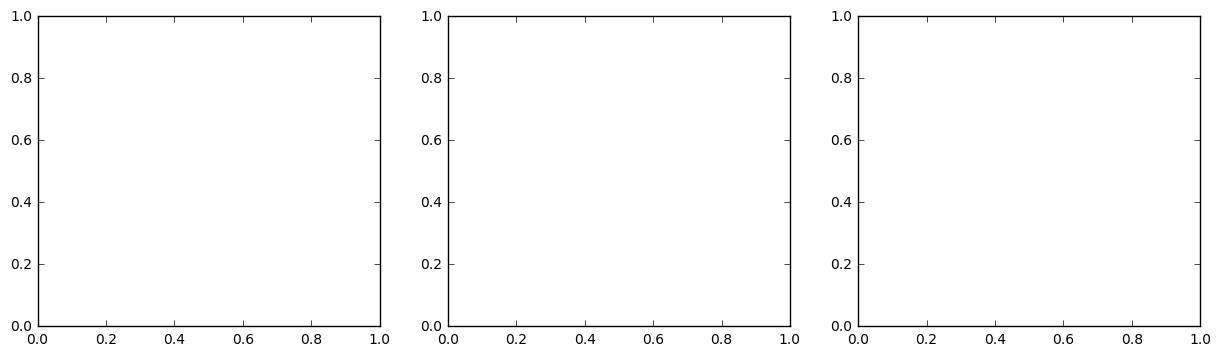

In [17]:
fig, ax = plt.subplots(1, 3, figsize = (15,4))

# Draw features regression plot
sns.regplot(x="vote_count", y="vote_average", data=movies,
                 color='#006bb3', marker="+", line_kws={"color":"yellow"}, ax=ax[0])
sns.regplot(x="revenue", y="vote_average", data=movies,
                 color='#006bb3', marker="+", line_kws={"color":"yellow"}, ax=ax[1])
sns.regplot(x="runtime", y="vote_average", data=movies,
                 color='#006bb3', marker="+", line_kws={"color":"yellow"}, ax=ax[2])

# Set ylim to vote_average 0-10
ax[0].set_ylim((0, 10))
ax[1].set_ylim((0, 10))
ax[2].set_ylim((0, 10))

- **popularity** gets higher, the vote_average grows definitely higher. The popularity can represent how the people love to watch this movie.

- **budget** does not really impact on the vote_average. The regression line is almost flat. Good movies can have a low budget or a high budget spent on them.

- **release_date** largely falls in 2001~2017. It seems that the old movies can get a better vote_average but I think it's because the old data was not well collected.

NameError: name 'sns' is not defined

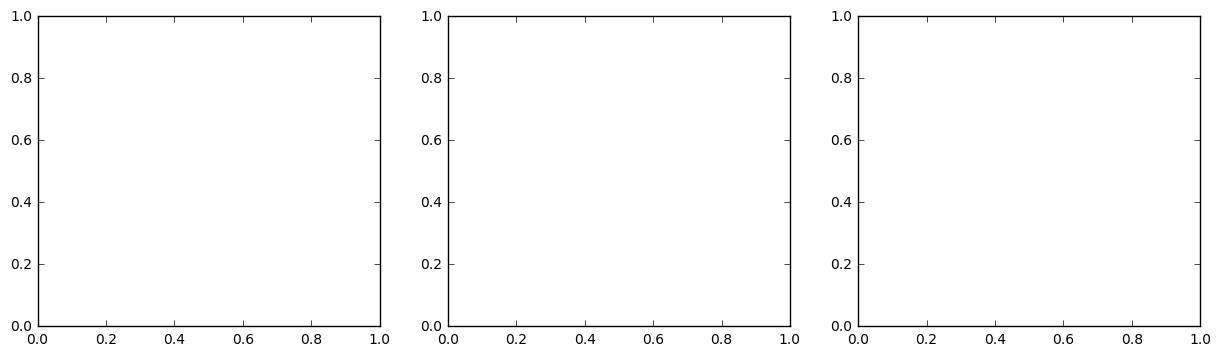

In [18]:
fig, ax = plt.subplots(1, 3, figsize = (15,4))

# Draw features regression plot
sns.regplot(x="popularity", y="vote_average", data=movies,
                 color='#4d0099', marker="^", line_kws={"color":"yellow"}, ax=ax[0])
sns.regplot(x="budget", y="vote_average", data=movies,
                 color='#009973', marker="v", line_kws={"color":"yellow"}, ax=ax[1])

# Set ylim to vote_average 0-10
ax[0].set_ylim((0, 10))
ax[1].set_ylim((0, 10))
ax[2].set_ylim((0, 10))

# Drop NaT in release_date
rlzDT = pd.DataFrame()
rlzDT = pd.concat([movies['release_date'], movies['vote_average']], axis=1)
index = pd.isnull(rlzDT).any(1).nonzero()[0]
rlzDT.drop(index, inplace=True)

# Draw release_date plot by date
ax=ax[2]
ax.plot_date(rlzDT.release_date, rlzDT.vote_average, fmt='.', color='#cc0052')
fig.autofmt_xdate()
ax.set_xlabel('release_date')
ax.set_ylabel('vote_average')

The `'vote_average'` shows a slighlty **left-skewed** distribution, and the highest distribution is around vote_average 6 to 8. This will be our target value, the classification will be set at 7.0, the good movies vote_average > 7.0 are labeld as 1, the other general movies with vote_average < 7.0 are labeled as 0.

In [19]:
sns.distplot(movies.vote_average)

NameError: name 'sns' is not defined

In [20]:
violin_raw = movies.copy()
violin_raw['vote_rank'] = violin_raw['vote_average'].apply(lambda x:1 if x >= 7.0 else 0)

NameError: name 'sns' is not defined

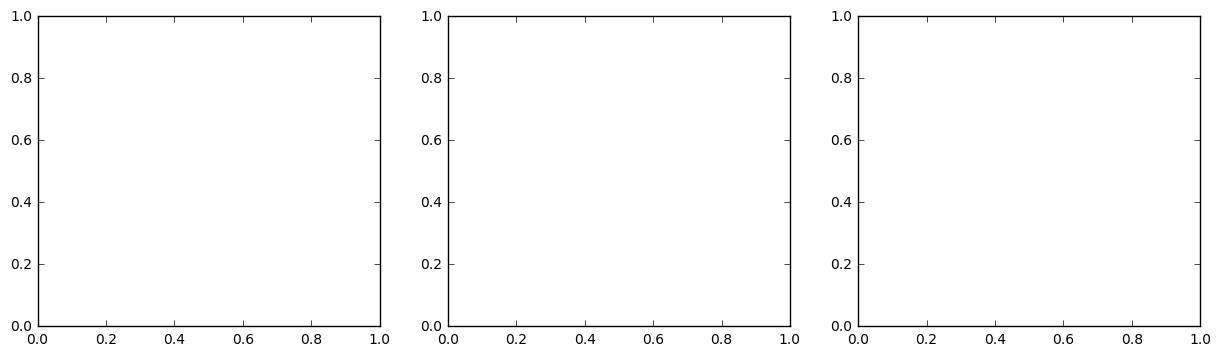

In [21]:
fig, ax = plt.subplots(1, 3, figsize = (15,4))

# Draw features regression plot
sns.violinplot(x="vote_rank", y="vote_count", hue="vote_rank", data=violin_raw, split=True,
               inner="quart", palette="Set2", ax=ax[0])
sns.violinplot(x="vote_rank", y="revenue", hue="vote_rank", data=violin_raw, split=True,
               inner="quart", palette="Set2", ax=ax[1])
sns.violinplot(x="vote_rank", y="runtime", hue="vote_rank", data=violin_raw, split=True,
               inner="quart", palette="Set2", ax=ax[2])

NameError: name 'sns' is not defined

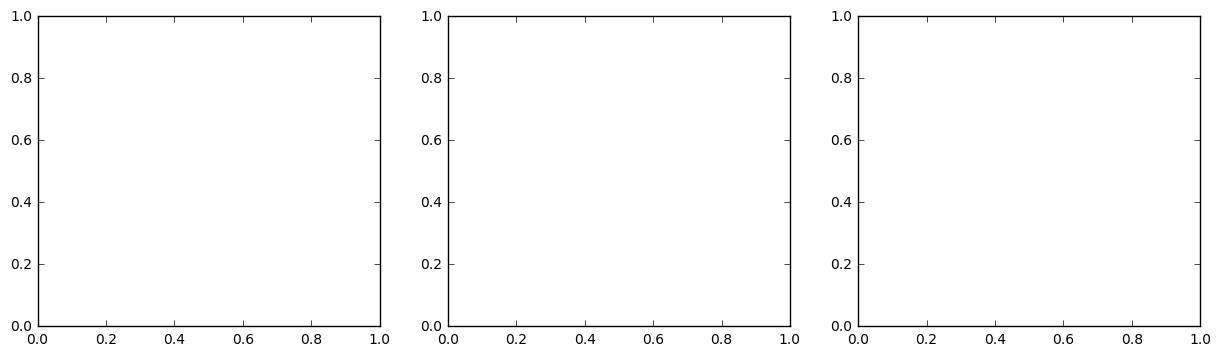

In [22]:
fig, ax = plt.subplots(1, 3, figsize = (15,4))

# Draw features regression plot
sns.violinplot(x="vote_rank", y="popularity", hue="vote_rank", data=violin_raw, split=True,
               inner="quart", palette="Set2", ax=ax[0])
sns.violinplot(x="vote_rank", y="budget", hue="vote_rank", data=violin_raw, split=True,
               inner="quart", palette="Set3", ax=ax[1])
sns.violinplot(x="vote_rank", y="vote_average", hue="vote_rank", data=violin_raw, split=True,
               inner="quart", palette="Set1", ax=ax[2])

## Algorithms and Techniques

The problem to predict a good movie is going to be a classification problem. The target value is separated by 7.0 and the good movie we want to find is those of voting 7.0 or higher. We use the Ensemble Methods of Supervised Learning to solve this problem. 

In this project, we want to figure out the feature importance and relevance to our target. We choose Ensemble Methods such as `'Ada Boost', 'Random Forest' and 'Gradient Boosting'` which can automatically learn feature interactions well. They can still handle lots of irrelevant features or outliers well, this characteristic can deal with some irrelevant features in json input data like movie keywords or genres. Besides, we also implement `'XGBoost'`, the outperforming method in Kaggle competition which is an advanced version of `'Gradient Boosting'`.

We use the default parameters implemented by learning models, for example in XGBoost, default min_child_weight=1, subsample=1. Furthermore, we will tune parameters to improve model performance in the Refinement section.

- **Ada Boost:** The boosting learning is trying to combine several weak learners to form a strong rules. It starts by a first learner predicting data set and gives equal weight to them. If certain data prediction is incorrect, it put higher weight on them. Iteratively adding learners and doing the previous process, it will stop until it reach the maximum number of models or accuracy.

- **Random Forest:** It uses the bagging learning to build many independent models and combine them using averaging methods like weighted average or majority voting. It builds each model by a decision tree which use some randomness in selecting the attribute to split at each node. The training data set is being sampling with replacement, the decision trees are fitted using the bootstrap samples and combined by voting the output.

- **Gradient Boosting:** It trains a sequence of model that gradually minimizes the loss function (the inaccuracy of the predictions) by using Gradient Descent (to take steps proportional to the negative of the gradient). The learning procedure consecutively fit new models for predicting a more accurate target value.

- **XGBoost:** It is called e**X**treme **G**radient **Boost**ing, an advanced version based on Gradient Boosting. XGBoost uses a more regularized model formalization to control the complexity of the model which can help to avoid over-fitting. The general principle of regularization is that it want both a simple and predictive model.


## Benchmark

We introduce `'Decision Tree'` to compare with our training models, according to the research [A movie recommender system based on inductive learning](http://ieeexplore.ieee.org/document/1460433/) and [Automatic movie ratings prediction using machine learning](http://ieeexplore.ieee.org/document/5967324/), the decision tree is often chosen to be the training model for movie data predicting voting values.

- **Decision Tree:** It trains a flowchart-like structure as a tree. First, it picks a best question (attribute) as a root node that split the data into subsets following the answer path (branch) and iteratively pick another question. Repeat it until all the questions are answered, the result (leaf node) will be a class label. The best attribute to choose is which we can get the most uncertainty decreased (maximum Information Gain).


## III. Methodology
----
## Data Preprocessing

- **Input data handling**: Includes data separation into features and target. Target data will be encoded into `0: rating < 7.0` and `1: rating >= 7.0` to represent a good movie.
- **Drop missing data**: Outliers with value 0 in any column that found in previous section will be dropped. Some missing data with value **NaN** will also be dropped.
- **Feature Scaling and Normalizing**: In order to solve data skewing problem, log transformation and MinMaxScaler will be applied to form a better feature distribution.
- **Json input handling**: Some data columns given as json format will be flattening and using WordCloud to pick the keywords as features. These features will apply one-hot encoding as new data input.
- **Training data separation**: Since we have 5000 movie datasets, we can split the data into Training sets(70%) and Testing sets(30%).

### Feature and Target

- **vote_average** is split from other data and copied as target data.
- The rest of columns(budget, popularity, release_date, revenue, status, vote_count) in movies data or credits data will be the feature data.
- Some movies data (genres, keywords, production_companies, production_countries, spoken_languages) or credits data(cast, crew) in json format will be excluded for preprocessing.
- Some features (id, spoken_languages, original_language, original_title, overview, tagline, title) are irrelevant or unmeasurable to our training results will be dropped.

In [23]:
# Set target = vote_average
target_raw = movies.copy()
target_raw = movies['vote_average']

# The rest of data will be features
features_raw = movies.copy()
features_raw2 = credits.copy()
features_raw.drop('vote_average', axis = 1, inplace=True)

In [24]:
features_drop_na = features_raw.copy()

# Drop irrelevant and unmeasurable features
features_drop_na.drop('id', axis = 1, inplace=True)
features_drop_na.drop('homepage', axis = 1, inplace=True) # web url is irrelevant
features_drop_na.drop('original_language', axis = 1, inplace=True) # focus on spoken_languages
features_drop_na.drop('original_title', axis = 1, inplace=True) # original_title is not measurable
features_drop_na.drop('overview', axis = 1, inplace=True) # overview is not measurable
features_drop_na.drop('tagline', axis = 1, inplace=True) # tagline is not measurable
features_drop_na.drop('title', axis = 1, inplace=True) # title is not measurable

# Drop json features
features_drop_na.drop('genres', axis = 1, inplace=True)
features_drop_na.drop('keywords', axis = 1, inplace=True)
features_drop_na.drop('production_companies', axis = 1, inplace=True)
features_drop_na.drop('production_countries', axis = 1, inplace=True)
features_drop_na.drop('spoken_languages', axis = 1, inplace=True)

features_drop_na.head(5)

,budget,popularity,release_date,revenue,runtime,status,vote_count
0,237000000,150.437577,2009-12-10,2787965087,162.0,Released,11800
1,300000000,139.082615,2007-05-19,961000000,169.0,Released,4500
2,245000000,107.376788,2015-10-26,880674609,148.0,Released,4466
3,250000000,112.312950,2012-07-16,1084939099,165.0,Released,9106
4,260000000,43.926995,2012-03-07,284139100,132.0,Released,2124


### Drop Missing data

In case the missing data will impact on the training result as a bad feature, we will drop them and reset the data row index.
- 1576 outliers with value 0 was indicated from the Data Exploration, they will be dropped.
- Missing data as below will also be dropped:

|     Feature    |  Value  | Count |
| :------------: | :-----: | :---: | 
| release_date   |   NaT   |   1   |
| runtime        |   NaN   |   2   |

In [25]:
# Collect missing data row index
nulls = pd.isnull(features_drop_na).any(1).nonzero()[0]

# Append missing data into 0 value outliers list
nas = np.asarray(missing_outliers)
for i in nulls:
    if i not in nas:
        print(i)
        nas = np.append(i, nas)

print('Missing data', len(nas))

Missing data 1576


After missing data dropped, the features have no 0 value described in the table. There are 3227 data row being left for training.

In [26]:
# Drop missing data for movies data
features_drop_na.drop(nas, inplace=True)
features_drop_na.reset_index(drop = True, inplace=True)
display(features_drop_na.describe())

,budget,popularity,revenue,runtime,vote_count
count,3.227000e+03,3227.000000,3.227000e+03,3227.000000,3227.000000
mean,4.067877e+07,29.051491,1.213181e+08,110.720793,977.893090
std,4.439974e+07,36.169863,1.863361e+08,20.970364,1414.538507
min,1.000000e+00,0.019984,5.000000e+00,41.000000,1.000000
25%,1.050000e+07,10.475904,1.704008e+07,96.000000,178.000000
50%,2.500000e+07,20.415572,5.519828e+07,107.000000,471.000000
75%,5.500000e+07,37.345773,1.463949e+08,121.000000,1148.000000
max,3.800000e+08,875.581305,2.787965e+09,338.000000,13752.000000


In [27]:
# Drop missing data for credits data
features_raw2.drop(nas, inplace=True)
features_raw2.reset_index(drop = True, inplace=True)
display(features_raw2.describe())

,movie_id
count,3227.000000
mean,44601.870778
std,74281.771931
min,5.000000
25%,4954.500000
50%,11442.000000
75%,45256.000000
max,417859.000000


In [28]:
# Drop missing data for target data
target_raw.drop(nas, inplace=True)
target_raw.reset_index(drop = True, inplace=True)
display(target_raw.describe())

count    3227.000000
mean        6.313263
std         0.859921
min         2.300000
25%         5.800000
50%         6.300000
75%         6.900000
max         8.500000
Name: vote_average, dtype: float64

### Feature Scaling

The numerical data is not normally distributed, according to the scatter_matrix plot, the data is highly right-skewed in some features. We apply **logarithmic transformation** on these features `'budget', 'popularity', 'revenue', 'vote_count'` to reduce the range of very large and very small values that may negatively affect the learning model to perform a bad result.

- skewness value > 0 means that there is more weight in the right tail of the distribution.

In [29]:
# Check data skewing value
from scipy import stats

stats.skew(features_raw[['budget', 'popularity', 'revenue', 'vote_count']])

array([ 2.43644981,  9.71837958,  4.44332822,  3.82287416])

In [30]:
# Log-transform to skewed features
skewed = ['budget', 'popularity', 'revenue', 'vote_count']

features_log_transformed = features_drop_na.copy()

features_log_transformed[skewed] = features_drop_na[skewed].apply(lambda x: np.log(x + 1))

features_log_transformed.describe()

,budget,popularity,revenue,runtime,vote_count
count,3227.000000,3227.000000,3227.000000,3227.000000,3227.000000
mean,16.801634,2.998848,17.496617,110.720793,6.038886
std,1.660813,0.935795,2.067760,20.970364,1.446256
min,0.693147,0.019787,1.791759,41.000000,0.693147
25%,16.166886,2.440250,16.651076,96.000000,5.187386
50%,17.034386,3.064118,17.826442,107.000000,6.156979
75%,17.822844,3.646644,18.801818,121.000000,7.046647
max,19.755682,6.776029,21.748578,338.000000,9.529012


** Release Date**

The feature `'release_date'` in datetime fromat will be transformed into days from then to 2018/1/1.

In [31]:
# Transform DateTime feature - from yyyy-mm-dd to days 
def toDays(di):
    dNow = date(2018, 1, 1)
    dRlz = date(di.year, di.month, di.day)
    delta = dNow - dRlz 
    return delta.days

features_log_transformed['release_date'] = features_drop_na['release_date'].apply(lambda x: toDays(x))
features_log_transformed['release_date'].head()

0    2944
1    3880
2     798
3    1995
4    2126
Name: release_date, dtype: int64

### Feature Normalizing

After applying feature scaling to data, we apply **normalization** to ensure that each feature is treated equally when applying supervised learners. 

In [32]:
# Features shrinked range into 0 to 1 (default)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
numerical = ['budget', 'popularity', 'revenue', 'runtime', 'vote_count', 'release_date']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed[numerical])
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])
features_log_minmax_transform.describe()

,budget,popularity,revenue,runtime,vote_count,release_date
count,3227.000000,3227.000000,3227.000000,3227.000000,3227.000000,3227.000000
mean,0.845034,0.440935,0.786942,0.234750,0.605005,0.144733
std,0.087124,0.138508,0.103612,0.070607,0.163680,0.132628
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.811736,0.358256,0.744573,0.185185,0.508636,0.058267
50%,0.857244,0.450595,0.803469,0.222222,0.618370,0.111388
75%,0.898605,0.536816,0.852343,0.269360,0.719058,0.179948
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### One-hot Encoding
We transform the feature `'status'` into new columns with value 0 or 1 by One-hot Encoding.

In [33]:
# One-hot encoding for feature 'status'
status = pd.get_dummies(features_drop_na['status'], prefix='status')

features_numerical = pd.concat([features_log_minmax_transform, status], axis=1)
features_numerical.head(5)

,budget,popularity,revenue,runtime,vote_count,release_date,status_Post Production,status_Released
0,0.975234,0.740114,1.000000,0.407407,0.982676,0.067479,0.0,1.0
1,0.987599,0.728577,0.946630,0.430976,0.873588,0.093102,0.0,1.0
2,0.976975,0.690595,0.942256,0.360269,0.872730,0.008733,0.0,1.0
3,0.978035,0.697187,0.952708,0.417508,0.953348,0.041500,0.0,1.0
4,0.980092,0.560260,0.885573,0.306397,0.788647,0.045086,0.0,1.0


We can see that after feature scaling and normalization, the feature `'popularity' and 'vote_count'` are turned into normal distribution. The highly right-skewed characteristic of the other features is decreased.

In [34]:
# Create plot after feature scaling
pd.plotting.scatter_matrix(features_log_minmax_transform, alpha = 0.3, figsize = (15,10), diagonal = 'kde');

AttributeError: module 'pandas' has no attribute 'plotting'

### Json Input Handling

We access the json data with some important keywords in each movie. The frequency of each keyword is collected from the **WordCloud**, we will pick the best of those as features because we want the data as much as possible to train. We will then apply **One-hot encoding** to those data as new feature data.

- **Credits**: Director, Actor
- **Movies**: genres, keywords, production_companies, production_countries, spoken_languages

In [35]:
# Find keywords in each movie; Return "NaN" when not finding values
# Return string instead of np.nan for later preprocessing 
def safe_access(container, index_values):
    result = container
    try:
        for idx in index_values:
            result = result[idx]
        return result
    except IndexError or KeyError:
        return "NaN"

In [40]:
# Find keywords in each movie; Return "NaN" when not finding values
# Return string instead of np.nan for later preprocessing 
def safe_access_with_logic(container, key, value, index):
    result=""
    try:
        for item in container:
            if item[key] == value:
                result = item[index]
        return result
    except IndexError or KeyError:
        return "NaN"

In [41]:
# Append data column value into list
def extend_list(container):
    data_list = []
    for i in range(len(container)):
        data_list.extend(container[i])        
    return pd.Series(data_list)

In [42]:
# Get actors and directors from the credits data
data = pd.DataFrame()
data['actor1'] = features_raw2.cast.apply(lambda x: safe_access(x, [0, 'name']))
data['actor2'] = features_raw2.cast.apply(lambda x: safe_access(x, [1, 'name']))
data['actor3'] = features_raw2.cast.apply(lambda x: safe_access(x, [2, 'name']))
data['director'] = features_raw2.crew.apply(lambda x: safe_access_with_logic(x, 'job', 'Director', 'name'))

result = []
for i in range(len(data['actor1'])):
    tmp = []
    tmp.append(data['actor1'][i])
    tmp.append(data['actor2'][i])
    tmp.append(data['actor3'][i])
    result.append(tmp)
data['actors'] = pd.Series(data=result)
    
data.iloc[0:5, 3:5]

,director,actors
0,James Cameron,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]"
1,Gore Verbinski,"[Johnny Depp, Orlando Bloom, Keira Knightley]"
2,Sam Mendes,"[Daniel Craig, Christoph Waltz, Léa Seydoux]"
3,Christopher Nolan,"[Christian Bale, Michael Caine, Gary Oldman]"
4,Andrew Stanton,"[Taylor Kitsch, Lynn Collins, Samantha Morton]"


** Word Cloud **

We use the [WordCloud](https://github.com/amueller/word_cloud) to generate the frequency in each json data keywords.

In [43]:
from wordcloud import WordCloud
# Generate a word cloud image
def createWordCloud(cnt, max_num, max_size):  
    wordcloud = WordCloud(background_color="black",
                          max_words=max_num, 
                          max_font_size=max_size);
    wordcloud.generate_from_frequencies(cnt)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

ImportError: No module named 'wordcloud'

In [44]:
# Create word count
# Skip NaN and empty string
def wordCount(text):    
    wordCnt = {}
    text = text.replace('', np.nan)
    text = text.replace('NaN', np.nan)
    text.dropna(axis=0)
    
    wordCnt = text.value_counts().to_dict()   
    return wordCnt

** Director **

- 1454 directors in credits data
- 50 top most directors are chosen

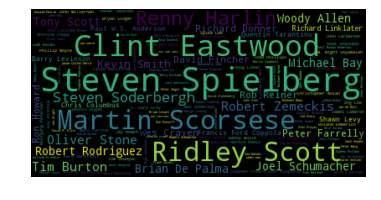

('director', 1454)
[(u'Steven Spielberg', 26), (u'Clint Eastwood', 19), (u'Ridley Scott', 16), (u'Martin Scorsese', 16), (u'Renny Harlin', 15), (u'Steven Soderbergh', 14), (u'Robert Zemeckis', 13), (u'Oliver Stone', 13), (u'Tim Burton', 13), (u'Tony Scott', 12), (u'Joel Schumacher', 12), (u'Brian De Palma', 12), (u'Robert Rodriguez', 12), (u'Woody Allen', 12), (u'Michael Bay', 12), (u'Kevin Smith', 11), (u'Peter Farrelly', 11), (u'Ron Howard', 11), (u'Richard Donner', 10), (u'Wes Craven', 10), (u'David Fincher', 10), (u'Rob Reiner', 10), (u'Richard Linklater', 10), (u'Francis Ford Coppola', 10), (u'Paul W.S. Anderson', 10), (u'Shawn Levy', 10), (u'Quentin Tarantino', 9), (u'Barry Levinson', 9), (u'Chris Columbus', 9), (u'M. Night Shyamalan', 9), (u'John Carpenter', 9), (u'Spike Lee', 9), (u'Rob Cohen', 9), (u'Peter Jackson', 9), (u'Danny Boyle', 8), (u'Sam Raimi', 8), (u'Christopher Nolan', 8), (u'John McTiernan', 8), (u'Lasse Hallstr\xf6m', 8), (u'F. Gary Gray', 8), (u'Alfred Hitchcoc

In [81]:
# Create word count
cnt = wordCount(data['director'])

# Create word cloud of top 200
createWordCloud(cnt,200,200)

# Get top 50 word count
director = sorted(cnt.items(), key=itemgetter(1), reverse=True)[:50]

print("director", len(cnt))
print(director)

** Actor **

- 3647 actors in credits data
- 100 top most actors are chosen

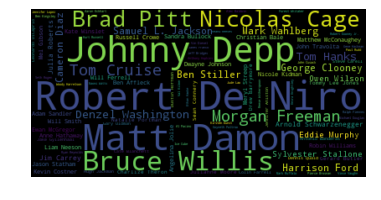

('actors', 3647)
[(u'Robert De Niro', 39), (u'Matt Damon', 33), (u'Johnny Depp', 31), (u'Bruce Willis', 31), (u'Nicolas Cage', 30), (u'Brad Pitt', 29), (u'Morgan Freeman', 28), (u'Tom Cruise', 28), (u'Denzel Washington', 28), (u'Tom Hanks', 27), (u'Mark Wahlberg', 27), (u'Harrison Ford', 27), (u'Ben Stiller', 27), (u'George Clooney', 26), (u'Cameron Diaz', 26), (u'Samuel L. Jackson', 25), (u'Sylvester Stallone', 25), (u'Owen Wilson', 25), (u'Eddie Murphy', 24), (u'Arnold Schwarzenegger', 24), (u'Julia Roberts', 23), (u'Jim Carrey', 23), (u'Matthew McConaughey', 22), (u'Ewan McGregor', 22), (u'Adam Sandler', 22), (u'John Travolta', 22), (u'Liam Neeson', 21), (u'Will Ferrell', 21), (u'Russell Crowe', 21), (u'Robin Williams', 20), (u'Christian Bale', 20), (u'Nicole Kidman', 20), (u'Will Smith', 20), (u'Ben Affleck', 20), (u'Meryl Streep', 20), (u'Sandra Bullock', 20), (u'Mel Gibson', 20), (u'Kevin Costner', 20), (u'Jason Statham', 19), (u'Anne Hathaway', 19), (u'Dwayne Johnson', 19), (u'K

In [82]:
data_list = extend_list(data['actors'])

# Create word count
cnt = wordCount(data_list)

# Create word cloud of top 200
createWordCloud(cnt,200,200)

# Get top 100 word count
actor = sorted(cnt.items(), key=itemgetter(1), reverse=True)[:100]

print("actors", len(cnt))
print(actor)

In [83]:
# Find keywords in each movie; Return "NaN" when not finding values
# Return string instead of np.nan for later preprocessing 
def safe_access_with_list(container, key):
    result = []
    try:
        for item in container:
            result.append(item[key])
        return result
    except IndexError or KeyError:
        return "NaN"

In [84]:
# Parsing json into list
data['genres'] = features_raw.genres.apply(lambda x: safe_access_with_list(x, 'name'))
data['keywords'] = features_raw.keywords.apply(lambda x: safe_access_with_list(x, 'name'))
data['production_companies'] = features_raw.production_companies.apply(lambda x: safe_access_with_list(x, 'name'))
data['production_countries'] = features_raw.production_countries.apply(lambda x: safe_access_with_list(x, 'name'))
data['spoken_languages'] = features_raw.spoken_languages.apply(lambda x: safe_access_with_list(x, 'name'))
data.iloc[0:5, 5:]

,genres,keywords,production_companies,production_countries,spoken_languages
0,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[Ingenious Film Partners, Twentieth Century Fo...","[United States of America, United Kingdom]","[English, Español]"
1,"[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...","[Walt Disney Pictures, Jerry Bruckheimer Films...",[United States of America],[English]
2,"[Action, Adventure, Crime]","[spy, based on novel, secret agent, sequel, mi...","[Columbia Pictures, Danjaq, B24]","[United Kingdom, United States of America]","[Français, English, Español, Italiano, Deutsch]"
3,"[Action, Crime, Drama, Thriller]","[dc comics, crime fighter, terrorist, secret i...","[Legendary Pictures, Warner Bros., DC Entertai...",[United States of America],[English]
4,"[Action, Adventure, Science Fiction]","[based on novel, mars, medallion, space travel...",[Walt Disney Pictures],[United States of America],[English]


** Genres **

- 19 movie genres in movies data
- 19 top most genres are chosen

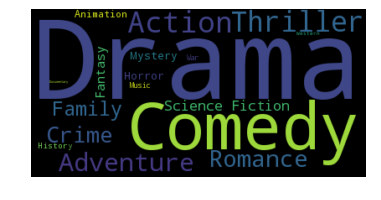

('genres', 19)
[(u'Drama', 1451), (u'Comedy', 1186), (u'Action', 957), (u'Thriller', 928), (u'Adventure', 703), (u'Romance', 595), (u'Crime', 500), (u'Family', 441), (u'Science Fiction', 424), (u'Fantasy', 372), (u'Horror', 277), (u'Mystery', 257), (u'Animation', 210), (u'History', 154), (u'Music', 119), (u'War', 117), (u'Western', 48), (u'Documentary', 12), (u'Foreign', 8)]


In [85]:
data_list = extend_list(data['genres'])

# Create word count
cnt = wordCount(data_list)

# Create word cloud of top 200
createWordCloud(cnt,200,200)

# Get top 20 word count
genre = sorted(cnt.items(), key=itemgetter(1), reverse=True)[:20]

print("genres", len(cnt))
print(genre)

** Keywords **

- 8131 movie keywords in movies data
- 100 top most keywords are chosen

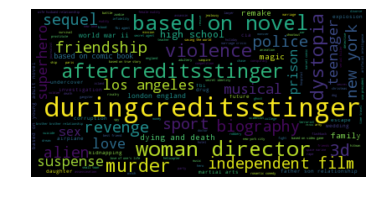

('keywords', 8131)
[(u'duringcreditsstinger', 276), (u'woman director', 170), (u'based on novel', 167), (u'aftercreditsstinger', 139), (u'murder', 123), (u'dystopia', 113), (u'violence', 112), (u'3d', 96), (u'sport', 90), (u'independent film', 89), (u'revenge', 86), (u'sequel', 83), (u'biography', 82), (u'friendship', 71), (u'alien', 69), (u'new york', 67), (u'police', 67), (u'los angeles', 67), (u'musical', 65), (u'superhero', 61), (u'suspense', 61), (u'love', 60), (u'teenager', 60), (u'prison', 56), (u'sex', 55), (u'high school', 54), (u'dying and death', 53), (u'family', 53), (u'magic', 51), (u'remake', 51), (u'based on comic book', 51), (u'london england', 50), (u'world war ii', 49), (u'father son relationship', 48), (u'fbi', 46), (u'drug', 45), (u'daughter', 45), (u'cia', 44), (u'corruption', 44), (u'kidnapping', 43), (u'martial arts', 43), (u'escape', 43), (u'undercover', 42), (u'wedding', 42), (u'investigation', 41), (u'explosion', 41), (u'airplane', 41), (u'future', 40), (u'bas

In [86]:
data_list = extend_list(data['keywords'])

# Create word count
cnt = wordCount(data_list)

# Create word cloud of top 200
createWordCloud(cnt,200,200)

# Get top 100 word count
keyword = sorted(cnt.items(), key=itemgetter(1), reverse=True)[:100]

print("keywords", len(cnt))
print(keyword)

** Production Companies **

- 3457 movie production companies in movies data
- 20 top most production companies are chosen

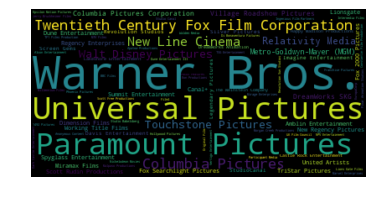

('production companies', 3457)
[(u'Warner Bros.', 298), (u'Universal Pictures', 279), (u'Paramount Pictures', 247), (u'Twentieth Century Fox Film Corporation', 191), (u'Columbia Pictures', 191), (u'New Line Cinema', 151), (u'Touchstone Pictures', 112), (u'Walt Disney Pictures', 108), (u'Relativity Media', 98), (u'Metro-Goldwyn-Mayer (MGM)', 94), (u'Village Roadshow Pictures', 80), (u'DreamWorks SKG', 78), (u'Columbia Pictures Corporation', 77), (u'Regency Enterprises', 67), (u'Miramax Films', 66), (u'Canal+', 62), (u'Dune Entertainment', 59), (u'Fox 2000 Pictures', 54), (u'TriStar Pictures', 50), (u'Amblin Entertainment', 49)]


In [87]:
data_list = extend_list(data['production_companies'])

# Create word count
cnt = wordCount(data_list)

# Create word cloud of top 200
createWordCloud(cnt,200,200)

# Get top 20 word count
prod_cmpy = sorted(cnt.items(), key=itemgetter(1), reverse=True)[:20]

print("production companies", len(cnt))
print(prod_cmpy)

** Production Countries **

- 67 movie production countries in movies data
- 5 top most production countries are chosen

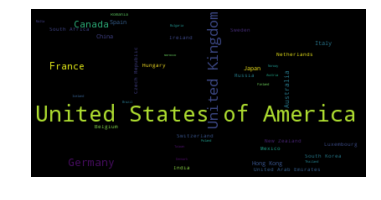

('production countries', 67)
[(u'United States of America', 2879), (u'United Kingdom', 452), (u'Germany', 271), (u'France', 221), (u'Canada', 170)]


In [88]:
data_list = extend_list(data['production_countries'])

# Create word count
cnt = wordCount(data_list)

# Creat word cloud of top 200
createWordCloud(cnt,200,200)

# Get top 5 word count
prod_ctry = sorted(cnt.items(), key=itemgetter(1), reverse=True)[:5]

print("production countries", len(cnt))
print(prod_ctry)

** Spoken languages **

- 56 movie spoken languages in movies data
- 5 top most spoken languages are chosen

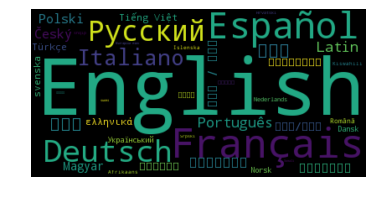

('spoken languages', 56)
[(u'English', 3119), (u'Fran\xe7ais', 321), (u'Espa\xf1ol', 261), (u'Deutsch', 176), (u'P\u0443\u0441\u0441\u043a\u0438\u0439', 161)]


In [89]:
data_list = extend_list(data['spoken_languages'])

# Create word count
cnt = wordCount(data_list)

# Create word cloud of top 200
createWordCloud(cnt,200,200)

# Get top 5 word count
language = sorted(cnt.items(), key=itemgetter(1), reverse=True)[:5]

print("spoken languages", len(cnt))
print(language)

### One-hot Encoding

Because there are so many features `('actors' has 3647 different values, 'keywords' has 8131 values)`, we do one-hot encoding on the features of higher frequency generated from WordCloud. The new feature column is named as `'feature_keyword'`. If the keyword value is appeared in this movie, then we apply 1 to the data, else apply 0.

In [45]:
# Manually do one-hot encoding
# Select candidate based on best frequency from word cloud
def one_hot_encoding(contanier, index_values, prefix_name):
    result = pd.DataFrame()
    prefix = prefix_name;
    
    for i in index_values:
        idx = i[0]
        result[prefix+idx] = contanier.map(lambda x: "|".join(x)) # Make a string of data contains indexes (Adventure|Fantasy|Action)
        result[prefix+idx] = result[prefix+idx].map(lambda x: 1 if idx in x else 0) # Check if index exist in data (Adventure=>1)
    return result

In [46]:
# Collect features
json_features = pd.DataFrame()
tuple_list = [(data['director'], director, "director_"),
              (data['actors'], actor, "actor_"),
              (data['genres'], genre, "genre_"), 
              (data['keywords'], keyword, "keyword_"),
              (data['production_companies'], prod_ctry, "prod_ctry_"),
              (data['production_countries'], prod_cmpy, "prod_cmpy_"),
              (data['spoken_languages'], language, "language_")]

# Do one-hot encoding for each feature
for t in tuple_list:
    tmp = one_hot_encoding(*t)
    json_features = pd.concat([json_features, tmp], axis=1)
json_features.head()

NameError: name 'director' is not defined

In [92]:
# Append preprocessing features 
features_preprocessed = pd.concat([features_numerical, json_features], axis=1)
print(features_preprocessed.shape)
features_preprocessed.head(5)

(3227, 307)


,budget,popularity,revenue,runtime,vote_count,release_date,status_Post Production,status_Released,director_Steven Spielberg,director_Clint Eastwood,...,prod_cmpy_Canal+,prod_cmpy_Dune Entertainment,prod_cmpy_Fox 2000 Pictures,prod_cmpy_TriStar Pictures,prod_cmpy_Amblin Entertainment,language_English,language_Français,language_Español,language_Deutsch,language_Pусский
0,0.975234,0.740114,1.000000,0.407407,0.982676,0.067479,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0
1,0.987599,0.728577,0.946630,0.430976,0.873588,0.093102,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0.976975,0.690595,0.942256,0.360269,0.872730,0.008733,0,1,0,0,...,0,0,0,0,0,1,1,1,1,0
3,0.978035,0.697187,0.952708,0.417508,0.953348,0.041500,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0.980092,0.560260,0.885573,0.306397,0.788647,0.045086,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


### Result Encoding
- The vote_average data is encoded into 0: value < 7.0 and 1: value >= 7.0 as the target value.
- Target data with voting >= 7.0 is **24%** in total data, while voting < 7.0 is **76%**

In [47]:
# 1: Good movie, 0: General movie, separated by vote=7.0
target = target_raw.apply(lambda x:1 if x >= 7.0 else 0)
num_general, num_good = (target.value_counts())
num_total = len(target)

print('vote >= 7.0', num_good, "{:.0f}%".format(num_good/num_total * 100))
print('vote <  7.0', num_general, "{:.0f}%".format(num_general/num_total * 100))

vote >= 7.0 768 24%
vote <  7.0 2459 76%


### Shuffle and Split Data
The 3227 data after preprocessing is split into training sets(2258) and testing sets(969) for model training.

In [48]:
from sklearn.model_selection import train_test_split
# training data:70%, testing data:30%
features_final = features_preprocessed.copy()
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    target, 
                                                    test_size = 0.30, 
                                                    random_state = 0)

print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

ImportError: No module named 'sklearn.model_selection'

## Implementation

We will introduce several benchmark methods and learning models to predict the movie data.

- **Benchmark:** Decision Tree.
- **Models**: Ada Boost, Random Forest, Gradient Boosting, XGBoost.
- **Metrics**: accuracy score, fbeta score, cv score, running time.

In [31]:
from sklearn.metrics import accuracy_score, fbeta_score
results = {} # Evaluating results of all models

### Decision Tree

The Decision Tree first picks a question as a root node `(ex:vote count > 4000?)`, that split the data into subsets following the answer path `(yes:count>4000; no:count<4000)`. Pick the other question `(ex:movie genre is drama?)` and iteratively repeat the previous steps until no more questions to answer and the result is reached `(ex:vote average = 1 or 0?)`.

---

- **Testing Accuracy Score** = *0.80* for testing sets which is not bad.
- **Testing F score** = *0.55* for testing sets, we should train other model to do better than it.
- **Training scores** = *1.0* while the testing result is low, which is obviously *over-fitting*.
- **CV Score** = *0.70*
- **Running time** is fast of < *0.1* sec.

In [231]:
def rocCurve(y_test, y_pred):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    i = 0
    
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred)
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.figure()
    lw = 2
    plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [232]:
# Evaluating the model performance by metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc

def train_predict(clf, X_train, y_train, X_test, y_test):    
    # Training
    t_start = time() # Get start time
    clf = clf.fit(X_train, y_train)
    t_end = time() # Get end time
    
    # Predicting
    p_start = time() # Get start time
    predictions_train = clf.predict(X_train)
    predictions_test = clf.predict(X_test)
    p_end = time() # Get end time
    
    results = {}
    # Get accuracy score
    results['acc_train'] = accuracy_score(y_train, predictions_train)
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    # Get F_Beta score
    results['f_train'] = fbeta_score(y_train, predictions_train, beta=0.5)
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
    # Get cross validation score
    cv_score = cross_val_score(clf, features_preprocessed, target)
    results['cv_score'] = cv_score.mean()
    # Get time performance
    results['train_time'] = t_end - t_start
    results['pred_time'] = p_end - p_start  

    rocCurve(y_test, predictions_test)
    
    return results

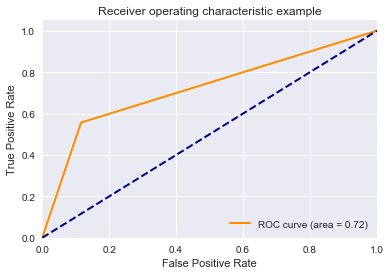

{'acc_test': 0.81217750257997934,
 'acc_train': 1.0,
 'cv_score': 0.68636782801648366,
 'f_test': 0.56949806949806947,
 'f_train': 1.0,
 'pred_time': 0.010999917984008789,
 'train_time': 0.09000015258789062}


In [233]:
# Training and Evaluating results of 'Decision Tree'
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()

results['Decision Tree'] = train_predict(dt, X_train, y_train, X_test, y_test)

pp.pprint(results['Decision Tree'])

### Ada Boost

It create a weak learner `(ex:vote count > 4000?)` to train the data set and put more weights on the incorrectly predicted data, ex: `(voting < 7.0)` was incorrectly predicted to be `(vote average = 1)`. After iterative adding new learners `(ex:popularity > 100?)` and repeat the processes, it will combine learners to form a strong rule to predict a good movie.

---

- **Testing Accuracy Score** = *0.83* which is better than decision tree.
- **Testing F score** = *0.60* which is better than decision tree.
- **Training scores** are lower than decision tree, *no over-fitting*.
- **CV Score** = *0.74* which is better than decision tree.
- **Running time** < *0.8* secs, predicting time is faster than training time.


- **Feature Importance** top ratings are numerical features add up to > 60% weights: `'vote_count', 'budget', 'runtime', 'popularity', 'revenue' and 'released_date'`. 
- I think it is because all the data have values in these numerical features unlike the json features after one-hot encoding which have little data marked as valid 1s. It is hard for the model to learn json features' characteristic.

In [145]:
# Show feature importnace plot for Ensemble methods
def feature_plot(importances, X_train, index):
    bar_width = 0.2
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:index]]
    # feature importance
    values = importances[indices][:index]

    fig = plt.figure(figsize = (11,6))
    plt.title("Normalized Weights for Top-{} Most Predictive Features".format(index), fontsize = 16)
    plt.bar(np.arange(index) - 0.2, values, width = bar_width, align="center", color='#80ccff', edgecolor='#000000',\
          label = "Feature Weight")
    plt.bar(np.arange(index), np.cumsum(values), width = bar_width, align="center", color='#005c99', edgecolor='#000000',\
          label = "Cumulative Feature Weight")
    plt.xticks(np.arange(index), columns, rotation=70)
    plt.xlim((-0.5, index-0.5))
    plt.ylabel("Weight", fontsize = 12)
    plt.xlabel("Feature", fontsize = 12)
    
    plt.legend(loc = 'upper center')
    plt.tight_layout()
    plt.show() 

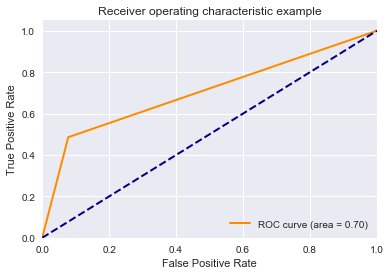

{'acc_test': 0.82662538699690402,
 'acc_train': 0.84853852967227639,
 'cv_score': 0.73967609002622403,
 'f_test': 0.59883720930232565,
 'f_train': 0.71229050279329609,
 'pred_time': 0.09100008010864258,
 'train_time': 0.5889999866485596}


In [225]:
# Training and Evaluating results of 'Ada Boost'
from sklearn.ensemble import AdaBoostClassifier

ab = AdaBoostClassifier()

results['Ada Boost'] = train_predict(ab, X_train, y_train, X_test, y_test)

pp.pprint(results['Ada Boost'])

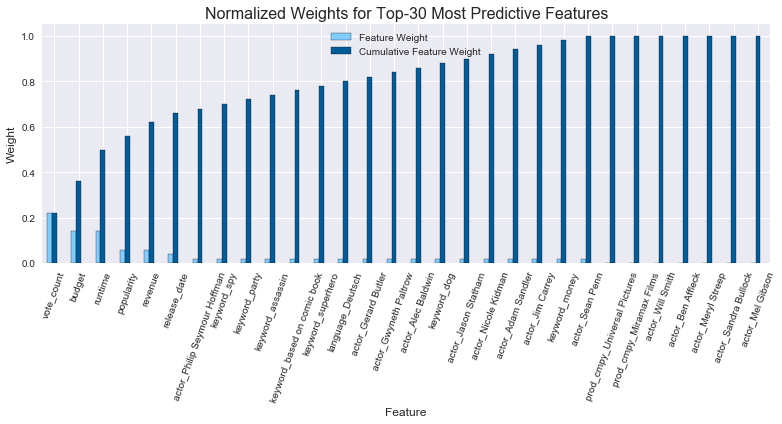

In [147]:
# Create plot feature importnace of 'Ada Boost'
ab_importances = ab.feature_importances_

feature_plot(ab_importances, X_train, 30)

### Random Forest

It builds many decision trees that use some randomness in selecting the attribute at each node. For example, the models are not allowed to ask the same question `(ex:movie genre is drama?)` because of randomness. 

The bootstrapped training data is also used, for example, Model_A is given the information that `(movie genre is 'drama' has higher voting average)` and `(movie genre is 'action' also has higher voting average)` while Model_B is given that `(movie genre is drama has 'much' higher voting average)` and `(movie genre is 'documentary' has 'lower' voting average)`.

The result will combine the decision trees (random forests) by voting the output.

---

- **Testing Accuracy Score** = *0.83* which is better than decision tree.
- **Testing F score** = *0.60* which need to be improved.
- **Training scores** = *0.98* which shows kind of *over-fitting*.
- **CV Score** = *0.74* which is better than decision tree.
- **Running time** < *0.2* secs which is faster than Ada Boost.


- **Feature Importance** top ratings add up to > 50% weights: `'vote_count', 'runtime', 'released_date', 'popularity', 'budget' and 'revenue'`. 
- **'vote_count'** is still the top-1 relevant feature. 
- Another features are `'genre_Comedy', 'genre_Drame' and 'genre_Thriller'` those add up to 60% movie genres in our data.

In [156]:
# Training and Evaluating results of 'Random Forest'
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

results['Random Forest'] = train_predict(rf, X_train, y_train, X_test, y_test)

pp.pprint(results['Random Forest'])

{'acc_test': 0.8286893704850361,
 'acc_train': 0.98184233835252432,
 'cv_score': 0.73967925996368977,
 'f_test': 0.59677419354838712,
 'f_train': 0.98106060606060608,
 'pred_time': 0.06000018119812012,
 'train_time': 0.1399998664855957}


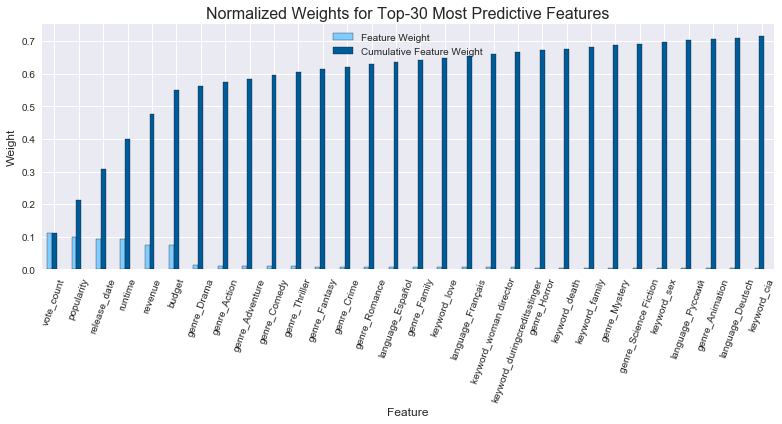

In [157]:
# Create plot feature importnace of 'Random Forest'

rf_importances = rf.feature_importances_

feature_plot(rf_importances, X_train, 30)

### Gradient Boosting

It trains a sequence of model that gradually minimizes the loss function (inaccuracy of the predictions). 

In detail steps:
`Y is target, M(x) is learning model, error_1 is the predicting inaccuracy.`

1. `Y = M(x) + error_1`: Guess error_1 have same correlation with target value (Y). It adds a model to predict error_1

2. `error_1 = G(x) + error_2`: Another model G(x) is fitted to predict the target value (error_1)

3. `Y = M(x) + G(x) + error_2`: Combine these process, it can get a better accuracy by minimizing the loss function

---

- **Testing Accuracy Score** = *0.84* which is better than decision tree and Ada Boost.
- **Testing F score** = *0.64* which is slightly improved.
- **Training scores** = *0.89* which is slightly *over-fitting*.
- **CV Score** = *0.75* which is better than Ada Boost.
- **Running time** < *2* secs, predicting time is much faster than the training time.


- **Feature Importance** top ratings add up to > 70% weights: `'vote_count', 'budget', 'runtime', 'released_date', 'revenue' and 'popularity'`. 
- **'vote_count'** is still the top-1 relevant feature. 
- Another features are `'actor_Alec Baldwin', 'actor_Sean Penn'`. The actors have acting in movies with voting average in both > 7.0 and < 7.0.

In [150]:
# Training and Evaluating results of 'Gradient Boosting'
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()

results['Gradient Boosting'] = train_predict(gb, X_train, y_train, X_test, y_test)

pp.pprint(results['Gradient Boosting'])

{'acc_test': 0.8410732714138287,
 'acc_train': 0.89371124889282549,
 'cv_score': 0.74865306475317717,
 'f_test': 0.64086294416243639,
 'f_train': 0.83255159474671669,
 'pred_time': 0.031000137329101562,
 'train_time': 1.7579998970031738}


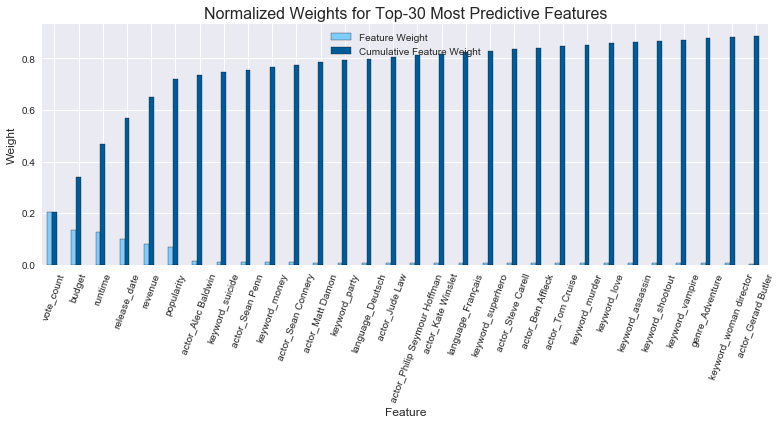

In [151]:
# Create plot feature importnace of 'Gradient Boosting'
gb_importances = gb.feature_importances_

feature_plot(gb_importances, X_train, 30)

### XGBoost

The data handling resembles to Gradient Boosting. Additionally, the Regularization formalization is used to control the complexity and avoid over-fitting.

![Regularization](./image/xgboost.png)

**XGBoost Regularization**
- T is the number of leaves in a boosting tree
- w is the score for each leaves
- The more leaves we have, the more free parameters we have. Thus the large the weights are, the more complex the model is.
- It penalizes the more number and the weights of leaves since the model is too complex.

---

- **Testing Accuracy Score** = *0.85* which is the best.
- **Testing F score** = *0.67* which is the best.
- **CV Score** = *0.76* which is the best.
- **Training scores** = *0.88* which is *no over-fitting*.
- **Running time** < *2.5* secs, predicting time is much faster than the training time.


- **Feature Importance** top ratings add up to >80% weights: `'vote_count', 'budget', 'runtime', 'released_date', 'revenue' and 'popularity'`. 
- **'vote_count'** is still the top-1 relevant feature. 
- Another features are `'actor_Alec Baldwin', 'language_Español', 'language_Français', 'language_Deutsch'.

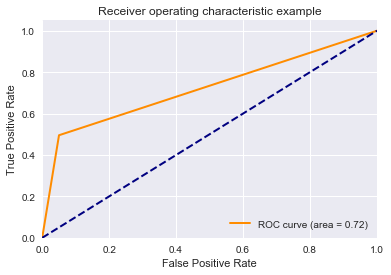

{'acc_test': 0.85036119711042313,
 'acc_train': 0.88263950398582813,
 'cv_score': 0.76167142157286527,
 'f_test': 0.6696428571428571,
 'f_train': 0.80910852713178294,
 'pred_time': 0.039999961853027344,
 'train_time': 1.3690001964569092}


In [226]:
# Refer to the code path
import os
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-7.2.0-posix-seh-rt_v5-rev1\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

# Training and Evaluating results of 'XGBoost'
import xgboost as xgb
xgbm = xgb.XGBClassifier()

results['XGBoost'] = train_predict(xgbm, X_train, y_train, X_test, y_test)

pp.pprint(results['XGBoost'])

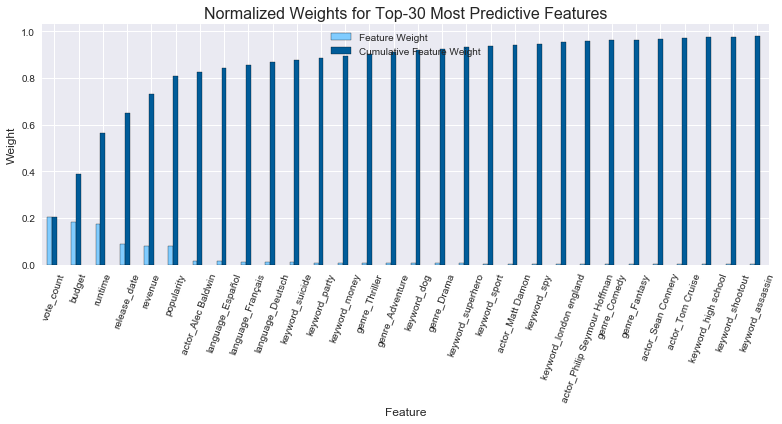

In [153]:
# Create plot feature importnace of 'XGBoost'
xgbm_importances = xgbm.feature_importances_

feature_plot(xgbm_importances, X_train, 30)

## Refinement

We choose the 2 best models `'XGBoost' and 'Gradient Boosting'` to apply the refinement methods. The `'feature selection'` is used for dimensionality reduction by training the most relevant features. The model parameters fine tuning are then applied to search for the best combination for the movie data sets.

### Feature Selection
Since we have 307 transferred features, we want to reduce the dimensionality for runtime saving. We apply feature selection to the movie data sets and choosing the most relevant features from 1 to 30 to see how many features can result to a best testing score.

In [114]:
from sklearn.feature_selection import SelectFromModel
# Feature Selection for refinement
def feature_select(clf, X_train, y_train, X_test, y_test, idx):
    thresholds = np.sort(clf.feature_importances_)[::-1][0:30]
    thresh_list = []

    for thresh in thresholds:    
        # selecting features using threshold
        selection = SelectFromModel(clf, threshold=thresh, prefit=True)
        
        # transform feature by selection model
        select_X_train = selection.transform(X_train)
        select_X_test = selection.transform(X_test)

        # training model
        if idx == 'gb':
            selection_model = GradientBoostingClassifier()
        elif idx == 'xgb':
            selection_model = xgb.XGBClassifier()
        selection_model.fit(select_X_train, y_train)

        # evaluating model
        pred_y = selection_model.predict(select_X_test)
        predictions = [round(value) for value in pred_y]
        accuracy = accuracy_score(y_test, predictions)
        
        thresh_tuple = ()
        thresh_tuple = (thresh, int(select_X_train.shape[1]), accuracy*100.0)
        thresh_list.append(thresh_tuple)
        
    # get the best score
    thresh_list = sorted(thresh_list, key=itemgetter(2), reverse=True)
    best_thresh = thresh_list[0]
    print(thresh_list[0])
    
    # select features by best score threshold
    selection = SelectFromModel(clf, threshold=best_thresh[0], prefit=True)
    select_X_train = selection.transform(X_train)
    select_X_test = selection.transform(X_test)

    return select_X_train, select_X_test

**XGBoost best features selected top 8:** `'vote_count', 'budget', 'runtime', 'released_date', 'revenue', 'popularity, actor_Alec Baldwin' and 'language_Español'`

In [115]:
# feature selection for XGBoost
select_X_train, select_X_test = feature_select(xgbm, X_train, y_train, X_test, y_test, 'xgb')

(0.014729951, 8, 85.758513931888544)


In [116]:
print(select_X_train.shape)
print(select_X_test.shape)

# train new model for feature selection data
select_xgbm = xgb.XGBClassifier()
select_xgbm = select_xgbm.fit(select_X_train, y_train)

(2258L, 8L)
(969L, 8L)


### Parameters Fine Tuning

We use GridSerachCV to evaluate the best parameters combination.

According to [xgboost](http://xgboost.readthedocs.io/en/latest/parameter.html) and [gradient boosting](https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/) parameters setting,  we choose some items for fine tuning to avoid overfitting:

- **min_child_weight** [default=1]
If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning. The larger min_child_weight will prevent the training from **over-fitting** while too high values can lead to under-fitting.

- **max_depth** [default=6]
Maximum depth of a tree, increase this value will make the model more complex and likely to be **over-fitting**. 

- **subsample** [default=1]
Subsample ratio of the training instance. It randomly collected a ratio of the data instances to grow trees and this will prevent **over-fitting**.

- **min_samples_leaf** [Gradient Boosting]
Defines the minimum samples required in a terminal node or leaf. Used to control **over-fitting**.


In [117]:
# Choose XGBoost and Gradient Boosting and the benchmark:Decision Tree for evaluating refinement
grid_results={}
grid_results['GB'] = results['Gradient Boosting']
grid_results['XGBoost'] = results['XGBoost']
grid_results['Decision Tree'] = results['Decision Tree']

In [118]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Parameter fine tuning for refinement
def paramFineTune(X_train, y_train, clf, parameters, scorer):
    
    # Get the best parameters setting
    start = time() # Get start time
    grid_obj = GridSearchCV(clf, parameters, scoring=scorer)
    grid_fit = grid_obj.fit(X_train, y_train)
    end=time() # Get end time
    best_clf = grid_fit.best_estimator_

    print("\nFinal solution:")
    print(best_clf)
    print("time: {}".format(end-start))
    
    return best_clf

### Initial solution - XGBoost
- max_depth=3
- min_child_weight=1
- subsample=1

In [119]:
print("Initial solution:")
print(xgbm)

Initial solution:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


In [120]:
parameters = {'min_child_weight':[2,3,4,5], 'max_depth':[1,2,3,4], 'subsample':[0.5,0.6,0.7,0.8]}

scorer = make_scorer(fbeta_score, beta=0.5)

# parameters tuning for XGBoost
best_xgbm = paramFineTune(select_X_train, y_train, select_xgbm, parameters, scorer)


Final solution:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=3, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)
time: 19.7459998131


### Final solution - XGBoost
- **max_depth: 3 => 3** Too high value will result to over-fitting.
- **min_child_weight: 1 => 3** Larger value will prevent over-fitting.
- **subsample: 1 => 0.8** It randomly collected ratio of data instances to grow trees to prevent over-fitting.

---

- **Testing Accuracy Score** = *0.86* which is better than original *0.85*.
- **Testing F score** = *0.69* which is better than original *0.67*.
- **CV Score** = *0.76* which is similar to original.
- **Training scores** = *0.88* which is similar to original.
- **Running time** < *0.4* secs which is much faster than the original *2 secs* because of **feature selection**.

In [121]:
# evaluating refinement for XGBoost
grid_results['XGB_Best'] = train_predict(best_xgbm, select_X_train, y_train, select_X_test, y_test)

pp.pprint(grid_results['XGB_Best'])

{'acc_test': 0.85758513931888547,
 'acc_train': 0.88131089459698853,
 'cv_score': 0.76446211924728391,
 'f_test': 0.68840579710144933,
 'f_train': 0.7990654205607477,
 'pred_time': 0.019999980926513672,
 'train_time': 0.4010000228881836}


---

### Initial solution - Gradient Boosting
- max_depth=3
- subsample=1.0
- min_samples_leaf=1

In [122]:
print("Initial solution:")
print(gb)

Initial solution:
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)


**Gradient Boosting best features selected top 6:** `'vote_count', 'budget', 'runtime', 'released_date', 'revenue' and 'popularity'`.

In [127]:
# feature selection for Gradient Boosting
select_X_train, select_X_test = feature_select(gb, X_train, y_train, X_test, y_test, 'gb')

(0.06936943556216224, 6, 85.242518059855527)


In [128]:
print(select_X_train.shape)
print(select_X_test.shape)

# train new model for feature selection data
select_gb = GradientBoostingClassifier()
select_gb = select_gb.fit(select_X_train, y_train)

(2258L, 6L)
(969L, 6L)


In [133]:
parameters = {'min_samples_leaf':[2,3,4,5], 'max_depth':[1,2,3,4], 'subsample':[0.5,0.6,0.7,0.8]}

scorer = make_scorer(fbeta_score, beta=0.5)

# parameters tuning for Gradient Boosting
best_gb = paramFineTune(select_X_train, y_train, select_gb, parameters, scorer)


Final solution:
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=2,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=0.6, verbose=0, warm_start=False)
time: 29.3480000496


### Final solution - Gradient Boosting
- **max_depth: 3 => 3** Too high value will result to over-fitting.
- **min_samples_leaf: 1 => 2** Larger value will prevent over-fitting.
- **subsample: 1 => 0.6** It randomly collected ratio of data instances to grow trees to prevent over-fitting.

---

- **Testing Accuracy Score** = *0.85* which is better than original *0.84*.
- **Testing F score** = *0.66* which is better than original *0.64*.
- **CV Score** = *0.76* which is better than original *0.75*.
- **Training scores** = *0.89* which is similar to the origin.
- **Running time** < *0.4* secs which is much faster than the original *2 secs* because of **feature selection**.

In [134]:
# evaluating refinement for Gradient Boosting
grid_results['GB_Best'] = train_predict(best_gb, select_X_train, y_train, select_X_test, y_test)
pp.pprint(grid_results['GB_Best'])

{'acc_test': 0.84623323013415896,
 'acc_train': 0.88928255093002662,
 'cv_score': 0.76291173165038462,
 'f_test': 0.65563725490196079,
 'f_train': 0.8179297597042513,
 'pred_time': 0.0,
 'train_time': 0.33100008964538574}


## IV. Results
----
## Model Evaluation and Validation

`'XGBoost' and 'Gradient Boosting'` both perform well on the movie data. After refinement, the feature selection can effectively reduce the training time without losing the testing accuracy and the parameter chosen can help the original model to prevent over-fitting and slightly improve the testing accuracy score.

**Feature Selection** makes the original 307 features to shrink to 6~8 features in the models. We use the accuracy score to evaluate the best feature combination. Also, we can see from the feature importance that the top 6 features has composed of > 70% total weight. Re-running the model after refinement, we can see the training time and the prediction time both improved largely because we choose only the best important features to train.

**Parameters Fine Tuning** focus on not to be over-fitting to the data. By using `'GrisSearchCV'`, we gave a series of candidates to train and the result shows that compared to the initial solution, the parameters increased or decreased to avoid over-fitting and slightly improve the final result.

**Cross-Validation** is utilized by 3-fold validation (cv-score) to improve the data robustness by each time selecting different testing set while the rest are the training sets from the input data. 

## Justification

- **XGBoost** has the best testing accuracy score and fbeta score in the first run learning models. Comparing to the benchmark `'Decision Tree'` that has the testing accuracy of 0.80, `'XGBoost'` is much better of 0.85. According to the f-beta score, we have the `'XGBoost'` of 0.67 and `'Decision Tree'` of 0.55. However, the training of `'XGBoost'` is 2.1 sec which is not good comparing to the `'Decision Tree'` is 0.08 sec.

- **XGBoost after refinement** has the best result in testing accuracy(0.857) which is better than the `'Gradient Boosting'`(0.846) after refinement and the training time of `'XGBoost Best`'(0.40s) is much better than `'XGBoost'`(2.14s). The great improvement of running time in `'XGBoost'` is because of the feature selection without losing the testing accuracy.

- **XGBoost** has the best result in cv-score, it shows the model robustness to the change of input data.

- According to the accuracy score, running time performance and the robustness to data, I would choose **XGBoost** to be the best model for the movie data.

In [170]:
# Create plot for model evaluation
def evaluate(results, idx):
    fig, ax = plt.subplots(2, 3, figsize = (11,7))
    bar_width = 0.25
    colors = ['#ff99cc','#85e085','#0099ff','#ffcc00','#9933ff']
    criterias = ['train_time', 'acc_train', 'f_train', 'pred_time', 'acc_test', 'f_test']
    length = len(results)
    if idx == 1: # index for model training
        columns = ['XGB', 'Ada', 'RF', 'GB', 'DT']
    elif idx == 2: # index for model refinement
        columns = ['DT', 'GB', 'GB_Best', 'XGB_Best', 'XGB']
    
    # Add x column data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(criterias):     
            ax[int(j/3), j%3].bar(k, results[learner][metric], width=bar_width, align="center", color=colors[k], edgecolor='#000000')
            ax[int(j/3), j%3].set_xticks(np.arange(length))
            ax[int(j/3), j%3].set_xticklabels(columns)
            ax[int(j/3), j%3].set_xlabel("Learning Models")
    
    # Add unique y-labels
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("Accuracy Score")
    ax[0, 2].set_ylabel("F-score")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("Accuracy Score")
    ax[1, 2].set_ylabel("F-score")
    
    # Add titles
    ax[0, 0].set_title("Model Training")
    ax[0, 1].set_title("Accuracy Score on Training Subset")
    ax[0, 2].set_title("F-score on Training Subset")
    ax[1, 0].set_title("Model Predicting")
    ax[1, 1].set_title("Accuracy Score on Testing Set")
    ax[1, 2].set_title("F-score on Testing Set")
    
    # Add horizontal lines for Benchmark
    dline = ax[0, 0].axhline(y = results['Decision Tree']['train_time'], label = 'Benchmark', xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 0].axhline(y = results['Decision Tree']['pred_time'], xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[0, 1].axhline(y = results['Decision Tree']['acc_train'], xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 1].axhline(y = results['Decision Tree']['acc_test'], xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[0, 2].axhline(y = results['Decision Tree']['f_train'], xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 2].axhline(y = results['Decision Tree']['f_test'], xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    
    # Set y-limits for score panels
    ax[0, 1].set_ylim((0, 1))
    ax[0, 2].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 1))
    ax[1, 2].set_ylim((0, 1))

    # Create column label
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i], label = learner))
    patches.append(dline)
    plt.legend(handles = patches, bbox_to_anchor = (-.80, 2.53), \
               loc = 'center', borderaxespad = 0., ncol = 6, fontsize = 'large')
    
    if idx == 1: # index for model training
        plt.suptitle("Performance Metrics for Learning Models", fontsize = 18, y = 1.10)
    elif idx == 2: # index for model refinement
        plt.suptitle("Performance Metrics for Model Refinement", fontsize = 18, y = 1.10)
    plt.tight_layout()
    plt.show()

### Learning model evaluation

- **Training time:** **Decision Tree** > Random Forest > Ada Boost > XGBoost > Gradient Boosting
- **Predicting time:** **Decision Tree** > Gradient Boosting > Random Forest > Ada Boost > XGBoost
- **Training Accuracy:** **Decision Tree** > Random Forest > Gradient Boosting > XGBoost > Ada Boost
- **Predicting Accuracy:** **XGBoost** > Gradient Boosting > Random Forest> Ada Boost > Decision Tree
- **Training F-Score:** **Decision Tree** > Random Forest > Gradient Boosting > XGBoost > Ada Boost
- **Predicting F-Score:** **XGBoost** > Gradient Boosting > Random Forest > Ada Boost > Decision Tree

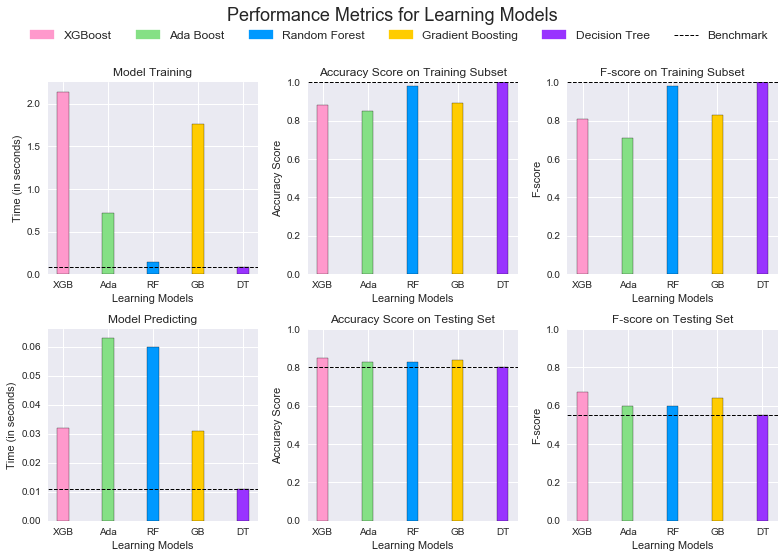

In [171]:
evaluate(results, 1)

### Refinement model evaluation

- **Training time:** **Decision Tree** > XGBoost Best > Gradient Boosting Best > XGBoost > Gradient Boosting
- **Predicting time:** **Gradient Boosting Best** > XGBoost Best > Gradient Boosting > Decision Tree > XGBoost
- **Training Accuracy:** **Decision Tree** > Gradient Boosting > Gradient Boosting Best > XGBoost > XGBoost Best
- **Predicting Accuracy:** **XGBoost Best** > Gradient Boosting Best > XGBoost > Gradient Boosting > Decision Tree
- **Training F-Score:** **Decision Tree** > Gradient Boosting > Gradient Boosting Best > XGBoost > XGBoost Best
- **Predicting F-Score:** **XGBoost Best** > Gradient Boosting Best > XGBoost > Gradient Boosting > Decision Tree

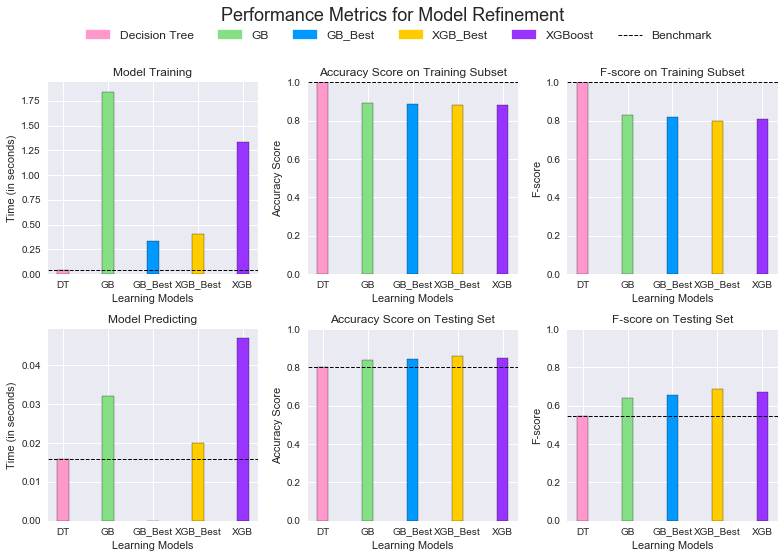

In [172]:
from collections import OrderedDict
sort_grid_results = OrderedDict(sorted(grid_results.items()))
evaluate(sort_grid_results, 2)

- **CV Score:** **XGBoost Best** > XGBoost > Gradient Boosting Best > Gradient Boosting > Ada Boost > Random Forest > Decision Tree

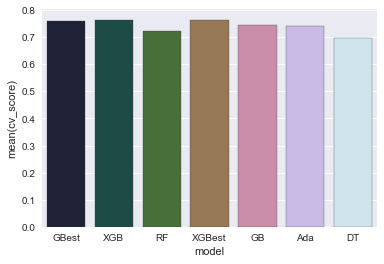

In [104]:
# Create plot for cv score
cvscore = {}
cvscore['DT'] = results['Decision Tree']['cv_score']
cvscore['Ada'] = results['Ada Boost']['cv_score'] 
cvscore['RF'] = results['Random Forest']['cv_score'] 
cvscore['XGB'] = results['XGBoost']['cv_score'] 
cvscore['GB'] = results['Gradient Boosting']['cv_score'] 
cvscore['XGBest'] = grid_results['XGB_Best']['cv_score']
cvscore['GBest'] = grid_results['GB_Best']['cv_score'] 

df = pd.DataFrame(cvscore.items(), columns=['model', 'cv_score'])

sns.barplot(x='model', y='cv_score', data=df, palette="cubehelix", errcolor=".2", edgecolor=".2");

## V. Conclusion
----
## Free-Form Visualization

- According to **feature importance** in the previous ensemble methods, they all show that the numerical features - `'vote_count', 'budget', 'runtime', 'released_date', 'revenue' and 'popularity'` are the best relevant features. The top 1 related feature is always be `'vote_count'`, that is, if there are more voting for the movie, the rating is more likely to be higher.

- We choose the best model `'XGBoost'` to show the feature importance. Combined with the **feature selection**, we indicate the top 8 relevant features which get the best score - `'vote_count', 'budget', 'runtime', 'released_date', 'revenue', 'popularity'`, `'actor_Alec Baldwin' and 'language_Español'`. The top 6 features are numerical features that each movie data should have a reasonable value in it after we drop the missing value data. I think the other json format features are not as important as those numericals because they are not valid in each movie. The feature actor and language are valid in movie data with voting average in both > 7.0 and < 7.0. 


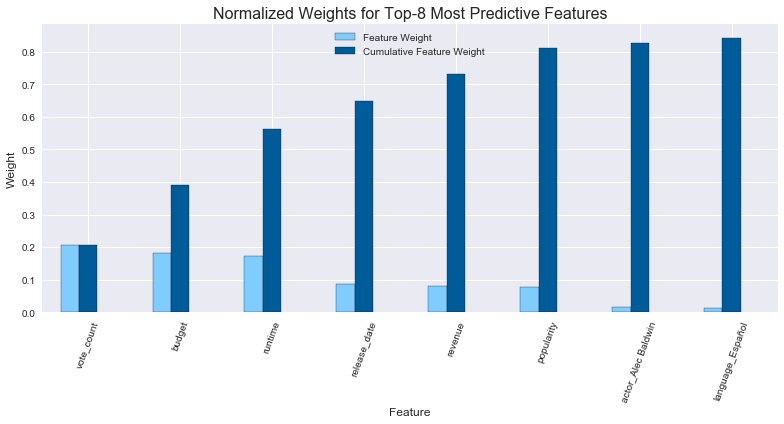

In [105]:
feature_plot(xgbm_importances, X_train, 8)

## Reflection

In this project, we use the **Supervised Learning** to predict the movie data voting average and find which features result into a higher rating. We have do some data preprocessing such as `'drop outliers' and 'feature scaling'` before the model training to keep the useful information and normalizing the data to be easy for training. After training, we also adopt some methods such as `'feature selection' and 'GridSearchCV'` to do model refinement. The target of training generated a best model - `'XGBoost'` to predict the movie data in high accuracy.

- It seems that the movie cast like actors or directors do not show big influence on movie voting. Though we sometimes think that certain actors or directors may create good movies. I think that maybe the feature sample is not as much as enough to learn. 

- Some relevant features like revenue or vote_count are information we only collect after the movie was made while that may be the reference to make the sequels.

- This movie data includes lots of json features to deal with, and it will make a large number of features if we flatten it. Some feature selection methods is needed to apply on it.

- The result accuracy which I expected to be better, but it's ok. The famous movie database online like IMDB can also used this model to predict while the input data need to be well prepared.

- About the data collected problem is that the old movie data is much less than the movie made in recent years. Other data features may be considered like awards, metascore, writers, certification ...

## Improvement

We want to introduce another method: **Unsupervised Learning** to look into the data information. We can use **PCA** to apply feature transformation on data. The data will be transformed into different clusters that best describe the movie data and we can use the unsupervised learning such as `'KMeans' or 'GaussianMixture'` to classify them into the clusters representing the good movie group or general movie group.

### Feature Transformation - PCA
- **PCA with 307 features**: The full features sets did not classify the clusters well. The best PC only got 0.082 scores.
- **PCA with 6 features**: Instead, we choose the outstanding features: `'budget', 'popularity', 'revenue', 'runtime', 'vote_count', 'release_date'` to apply PCA. The results show 2 PCs add to about 0.81 that covers a great portion of feature distribution.
- **1st PC = 0.62** with all the 6 features are negative-weighted. It may indicate a cluster with bad popularity, revenue, ... Compared to the data, we guess that it represents the vote < `7.0`.
- **2nd PC = 0.19** with 5 features appears in positive-weighted. We guess the clusters represents the vote >= `7.0`. The key why they are voting high has many reasons like high revenue, high popularity or high vote count.

In [106]:
from sklearn.decomposition import PCA
def pca_plot(good_data, pca):

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = good_data.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (11,6))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)


    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

In [107]:
def pca_transform(index, pre_i, post_i, is_plot):
    
    # Create PCA by n dimensions
    pca = PCA(n_components=index)

    # Prepare n features data
    features_pca = pd.DataFrame(data=features_final.iloc[:, pre_i:post_i])

    # Transform PCA
    pca.fit(features_pca)
    
    # Show result
    print(pca.explained_variance_ratio_)
    
    # Create plot
    if is_plot:
        pca_results = pca_plot(features_pca, pca)
    
    return (pca, features_pca)

In [108]:
# Create PCA by full set features in 2-D
fullsets, full_pca = pca_transform(2,0,307,False)

[ 0.08228251  0.0747929 ]


[ 0.61860451  0.19213774]


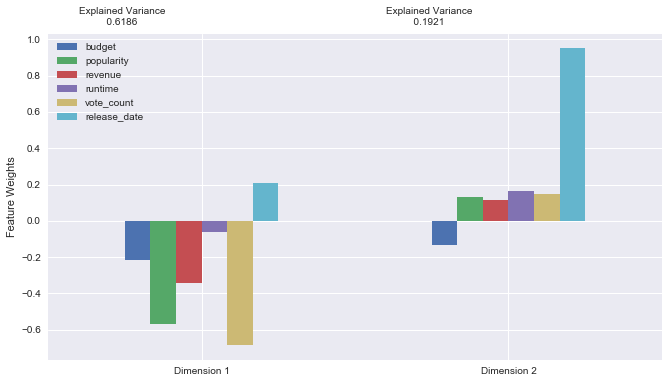

In [110]:
# Create PCA by top-6 features in 2-D
pca, features_pca = pca_transform(2,0,6,True)

In [131]:
dl_features = features_numerical.as_matrix()
dl_target = target.as_matrix()

(dl_x_train, dl_x_test) = dl_features[:2000], dl_features[2000:]
(dl_y_train, dl_y_test) = dl_target[:2000], dl_target[2000:]

print(dl_x_train.shape, 'train samples')
print(dl_x_test.shape, 'test samples')

(2000, 8) train samples
(1227, 8) test samples


In [132]:
from keras.models import Sequential
from keras.layers import Dense

def create_model():
    model = Sequential()
    model.add(Dense(8, input_dim=8, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

    model.summary()
    return model

In [133]:
from keras.wrappers.scikit_learn import KerasClassifier

estimator = KerasClassifier(build_fn=create_model, epochs=100, batch_size=5, verbose=1)
estimator.fit(dl_x_train, dl_y_train)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 9         
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
2000/2000 [==============================] - 1s - loss: 0.6064 - acc: 0.8000     
Epoch 2/100
2000/2000 [==============================] - 0s - loss: 0.5139 - acc: 0.8000     
Epoch 3/100
2000/2000 [==============================] - 0s - loss: 0.5082 - acc: 0.8000     
Epoch 4/100
2000/2000 [==============================] - 0s - loss: 0.5062 - acc: 0.8000     
Epoch 5/100
2000/2000 [==============================] - 0s - loss: 0.5051 - acc: 0.8000     
Epoch 6/100
2000/2000 [==============================] - 0s - loss: 0.50

In [135]:
from sklearn.metrics import accuracy_score
dl_pred_test = estimator.predict(dl_x_test)

results = accuracy_score(dl_y_test, dl_pred_test)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

 850/1227 [===================>..........] - ETA: 0sResults: 78.73% (0.00%)
